(chap3_5)=

# 5. Splines

In this chapter we will discuss splines, which is an extension of
concepts introduced into Chapter [3](chap2) with the aim of
adding more flexibility. In the models introduced in Chapter
[3](chap2) the relationship between the dependent and
independent variables was the same for their entire domain. Splines, in
contrast, can split a problem into multiple local solutions, which can
all be combined to produce a useful global solution. Let us see how.

(polynomial-regression)=

## 5.1 Polynomial Regression

As we already saw in Chapter [3](chap2), we can write a linear
model as:

```{math} 
:label: eq:lin_model
\mathbb{E}[Y]= \beta_0 + \beta_1 X

```

where $\beta_0$ is the intercept, $\beta_1$ the slope and
$\mathbb{E}[Y]$ is the expected value, or mean, of the response (random)
variable $Y$. We can rewrite Equation {eq}`eq:lin_model` into the
following form:

```{math} 
:label: eq:polynomial_reg
\mathbb{E}[Y]= \beta_0 + \beta_1 X + \beta_2 X^2 + \cdots + \beta_m X^m

```

This is known as polynomial regression. At first it may seem that
Expression {eq}`eq:polynomial_reg` is representing a multiple linear
regression of the covariates $X, X^2 \cdots + X^m$. And in a sense this
is right, but the key element to notice and keep in mind is that the
covariates $X^m$ are all derived from $X$ by applying successive powers
from 1 to $m$. So in terms of our actual problem we are still fitting a
single predictor.

We call $m$ the degree of the polynomial. The linear regressions models
from Chapter [3](chap2) and Chapter [4](chap3) were all
polynomials of degree $1$. With the one exception of the varying
variance example in Section
{ref}`transforming_covariates` where we used
$m=1/2$.

{numref}`fig:polynomial_regression` shows 3 examples of such polynomial
regression using degrees 2, 10, and 15. As we increase the order of the
polynomial, we get a more flexible curve.

```{figure} figures/polynomial_regression.png
:name: fig:polynomial_regression
:width: 8.00in
An example of polynomial regression with degrees 2, 10 and 15. As the
degree increases the fit gets more *wiggly*. The dashed lines are the
fit when removing the observation indicated with a blue cross. The
removal of a data point has a small effect when the degree of polynomial
is 2 or 10, but larger when the degree is 15. The fit was calculated
using the least squares method.
```

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="hdi currently interprets 2d data as")

import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc as pm
from patsy import bs, dmatrix

from scripts.splines import splines

In [2]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(435)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.5),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.5),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.5),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.5),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.3),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.3),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.3),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.3)]

In [3]:
x = np.random.normal(0.5, 1, 50)
y = np.random.normal(x**2, 1)

/tmp/ipykernel_88649/3561075106.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")


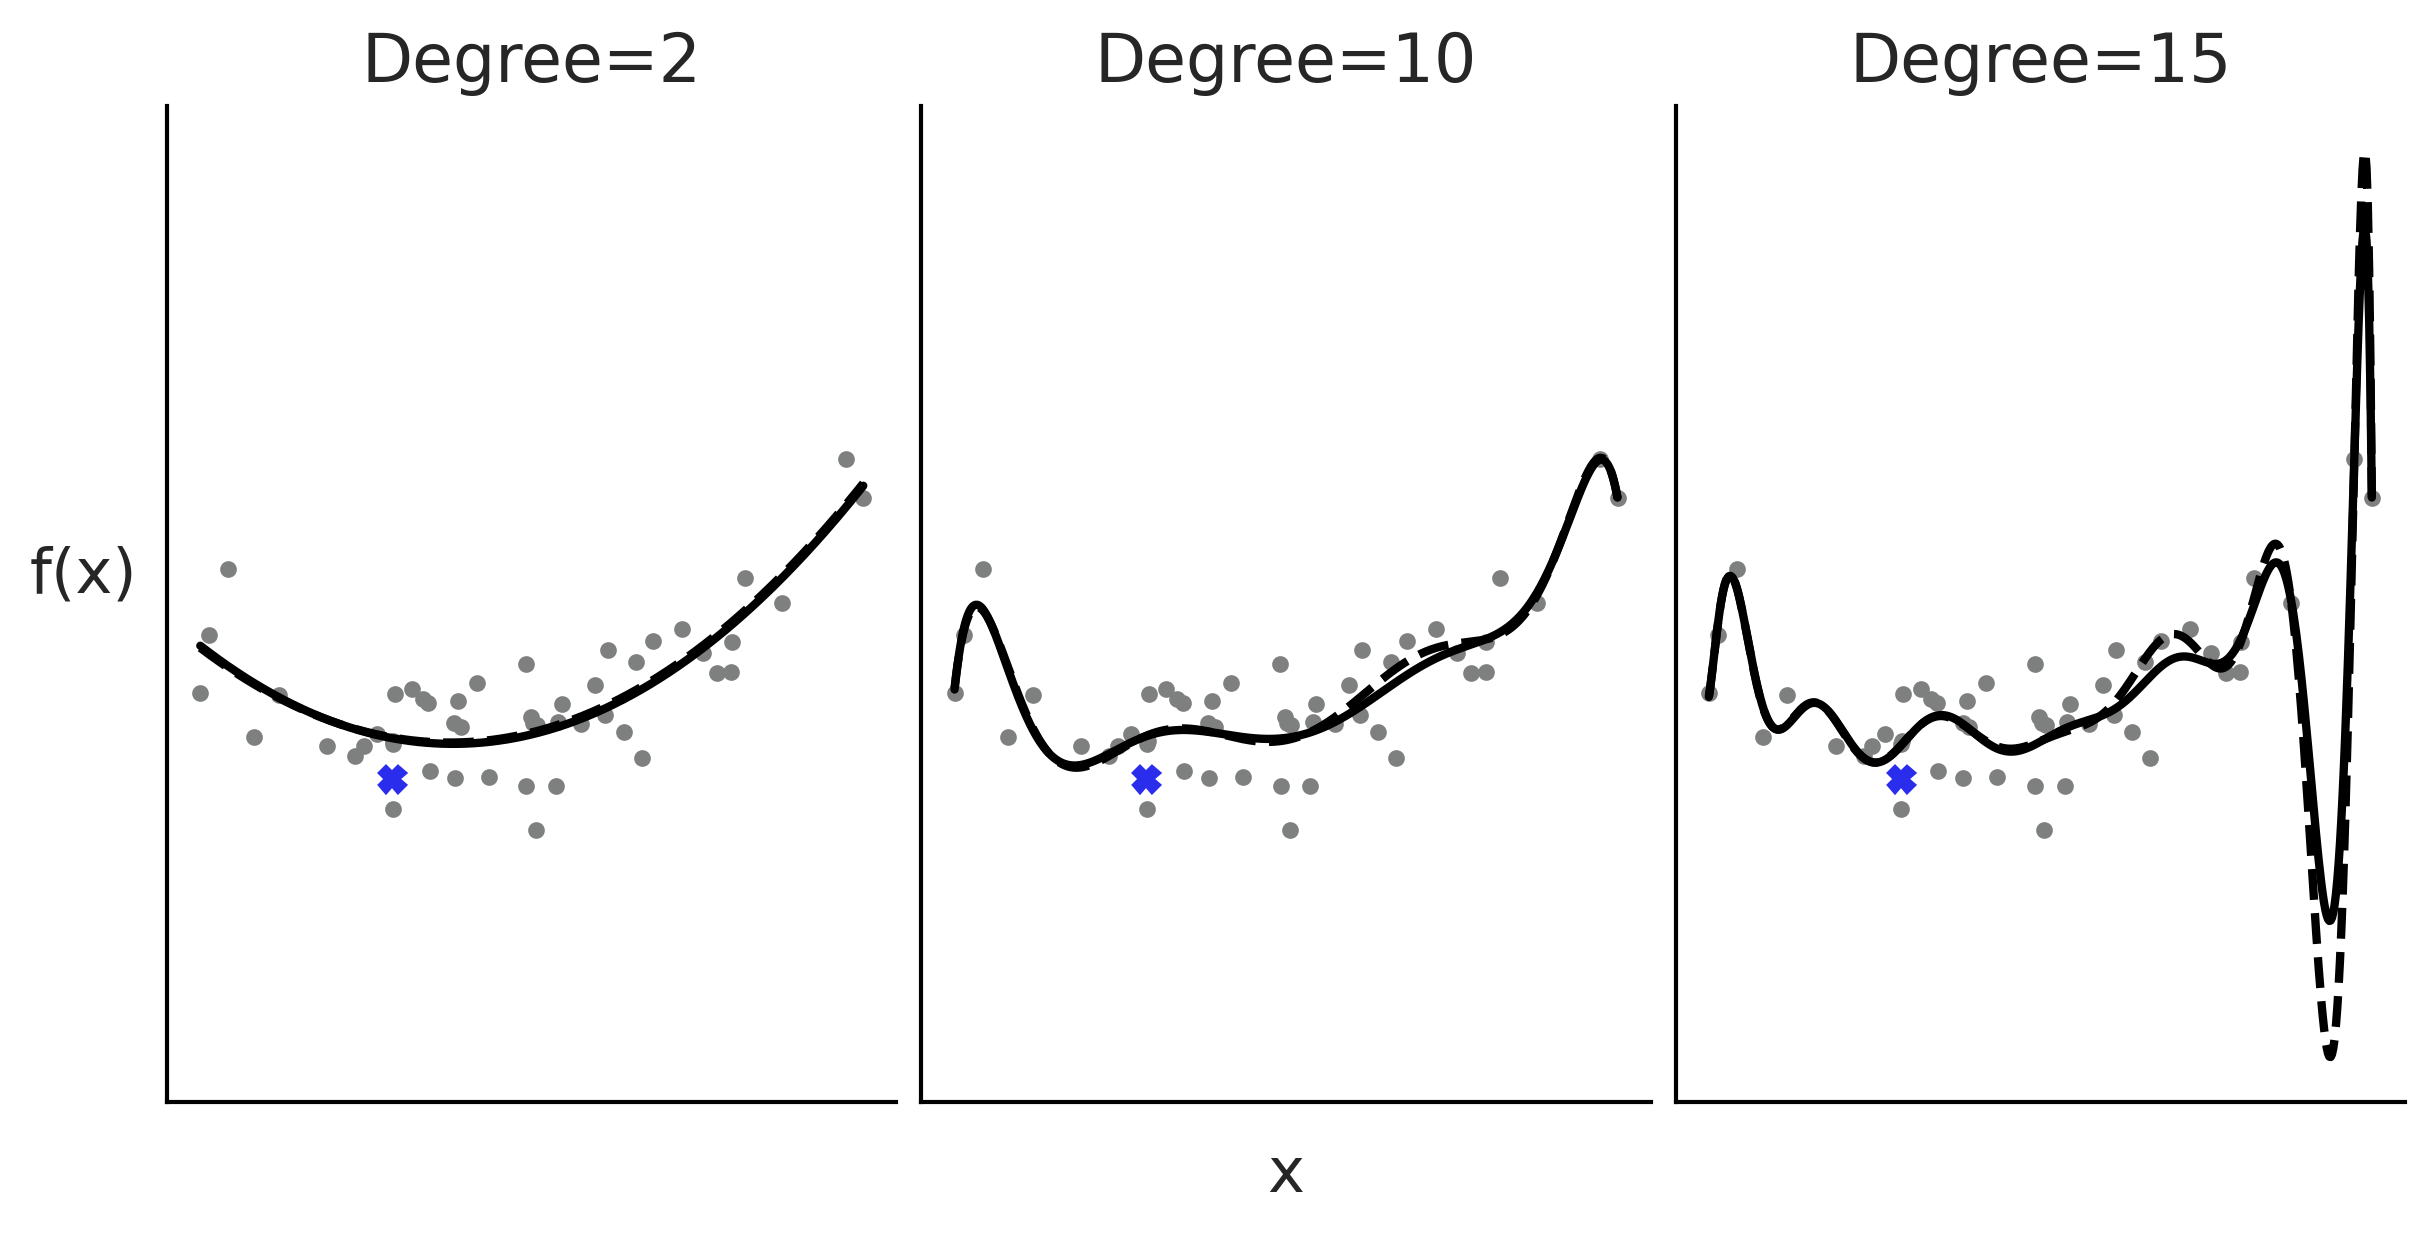

In [4]:
x_ = np.linspace(x.min(), x.max(), 500)
import warnings
warnings.filterwarnings("ignore", message="hdi currently interprets 2d data as")

_, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

for deg, ax in zip([2, 10, 15], axes):
    ax.plot(x, y, 'C2.')
    ax.set_title(f"Degree={deg}")
    coefs = np.polyfit(x, y, deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2)

    coefs = np.polyfit(x[:-1], y[:-1], deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2, ls="--")
    ax.plot(x[0], y[0], 'C0X', color="C4")


axes[1].set_xlabel("x", labelpad=10)
axes[0].set_ylabel("f(x)", rotation=0, labelpad=20)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("img/chp05/polynomial_regression.png")

One problem with polynomials is that they act *globally*, when we apply
a polynomial of degree $m$ we are saying that the relationship between
the independent and dependent variables is of degree $m$ for the entire
dataset. This can be problematic when different regions of our data need
different levels of flexibility. This could lead, for example, to curves
that are *too flexible* [^1]. For example, in the last panel of
{numref}`fig:polynomial_regression` (degree=15), we can see that the
fitted curve presents a *deep valley* followed by a *high peak* towards
high values of $X$, even when there are no data points with such low or
high values.

Additionally, as the degree increases the fit becomes more sensitive to the
removal of points, or equivalently to the addition of future data. In
other words as the degree increases, the model becomes more prone to
overfitting. For example, in {numref}`fig:polynomial_regression` the
black lines represent the fit to the entire data and the dashed lines
the fit when we remove one data point, indicated with a cross in the
figure. We can see, especially in the last panel, that removing even a
single data point changes the model fit with effects even far away from
the location of the point.

[^1]: See Runge's phenomenon for details. This can also be seen from
    Taylor's theorem, polynomials will be useful to approximate a
    function close to a single given point, but it will not be good over
    its whole domain. If you got lost try watching this video
    <https://www.youtube.com/watch?v=3d6DsjIBzJ4>.

(expanding_feature_space)=

## 5.2 Expanding the Feature Space

At a conceptual level we can think of polynomial regression as a recipe
for creating new predictors, or in more formal terms to **expanding the
feature space**. By performing this expansion we are able to fit a line
in the expanded space which gives us a curve on the space of the
original data, pretty neat! Nevertheless, feature expansion is not an
invitation to statistical anarchy, we can not just apply random
transformations to our data and then expect to always get good results.
In fact, as we just saw applying polynomials is not problem-free.

To generalize the idea of feature expansion, beyond polynomials we can
expand Equation {eq}`eq:lin_model` into the following form:

```{math} 
:label: eq:bfr
\mathbb{E}[Y]= \beta_0 + \beta_1 B_{1}(X_{1}) + \beta_2 B_{2}(X_{2}) + \cdots + \beta_m B_{m}(X_{m})

```

where the $B_i$ are arbitrary functions. In this context we call these
functions basis functions. A linear combination of them gives us a
function $f$ that is what we actually "see" as the fit of the model to
the data. In this sense the $B_i$ are an under the hood trick to build a
flexible function $f$.

```{math} 
:label: eq:bfr2
\mathbb{E}[Y]= \sum_i^m \beta_i B_{i}(X_{i}) = f(X)

```

There are many choices for the $B_i$ basis functions, we can use
polynomials and thus obtain polynomial regression as we just saw, or
maybe apply an arbitrary set of functions such as a power of two, a
logarithm, or a square root. Such functions may be motivated by the
problem at hand, for example, in Section
{ref}`transforming_covariates` we modeled how
the length of babies changes with their age by computing the square root
of the length, motivated by the fact that human babies, same as other
mammals, grow more rapidly in the earlier stages of their life and then
the growth tends to level off (similar to how a square root function
does).

Another alternative is to use indicator functions like
$I(c_i \leq x_k < c_j)$ to break up the original $\boldsymbol{X}$
predictor into (non-overlapping) subsets. And then fit polynomial
*locally*, i.e., only inside these subsets. This procedure leads to
fitting **piecewise polynomials** [^2] as shown in
{numref}`fig:piecewise`.

```{figure} figures/piecewise.png
:name: fig:piecewise
:width: 8.00in
The blue line is the *true* function we are trying to approximate. The
black-solid lines are piecewise polynomials of increasing order (1, 2,
3, and 4). The dashed vertical gray lines are marking the limits of each
subdomain on the x-axis.
```

[^2]: A piecewise function is a function that is defined using
    sub-functions, where each sub-function applies to a different
    interval in the domain.

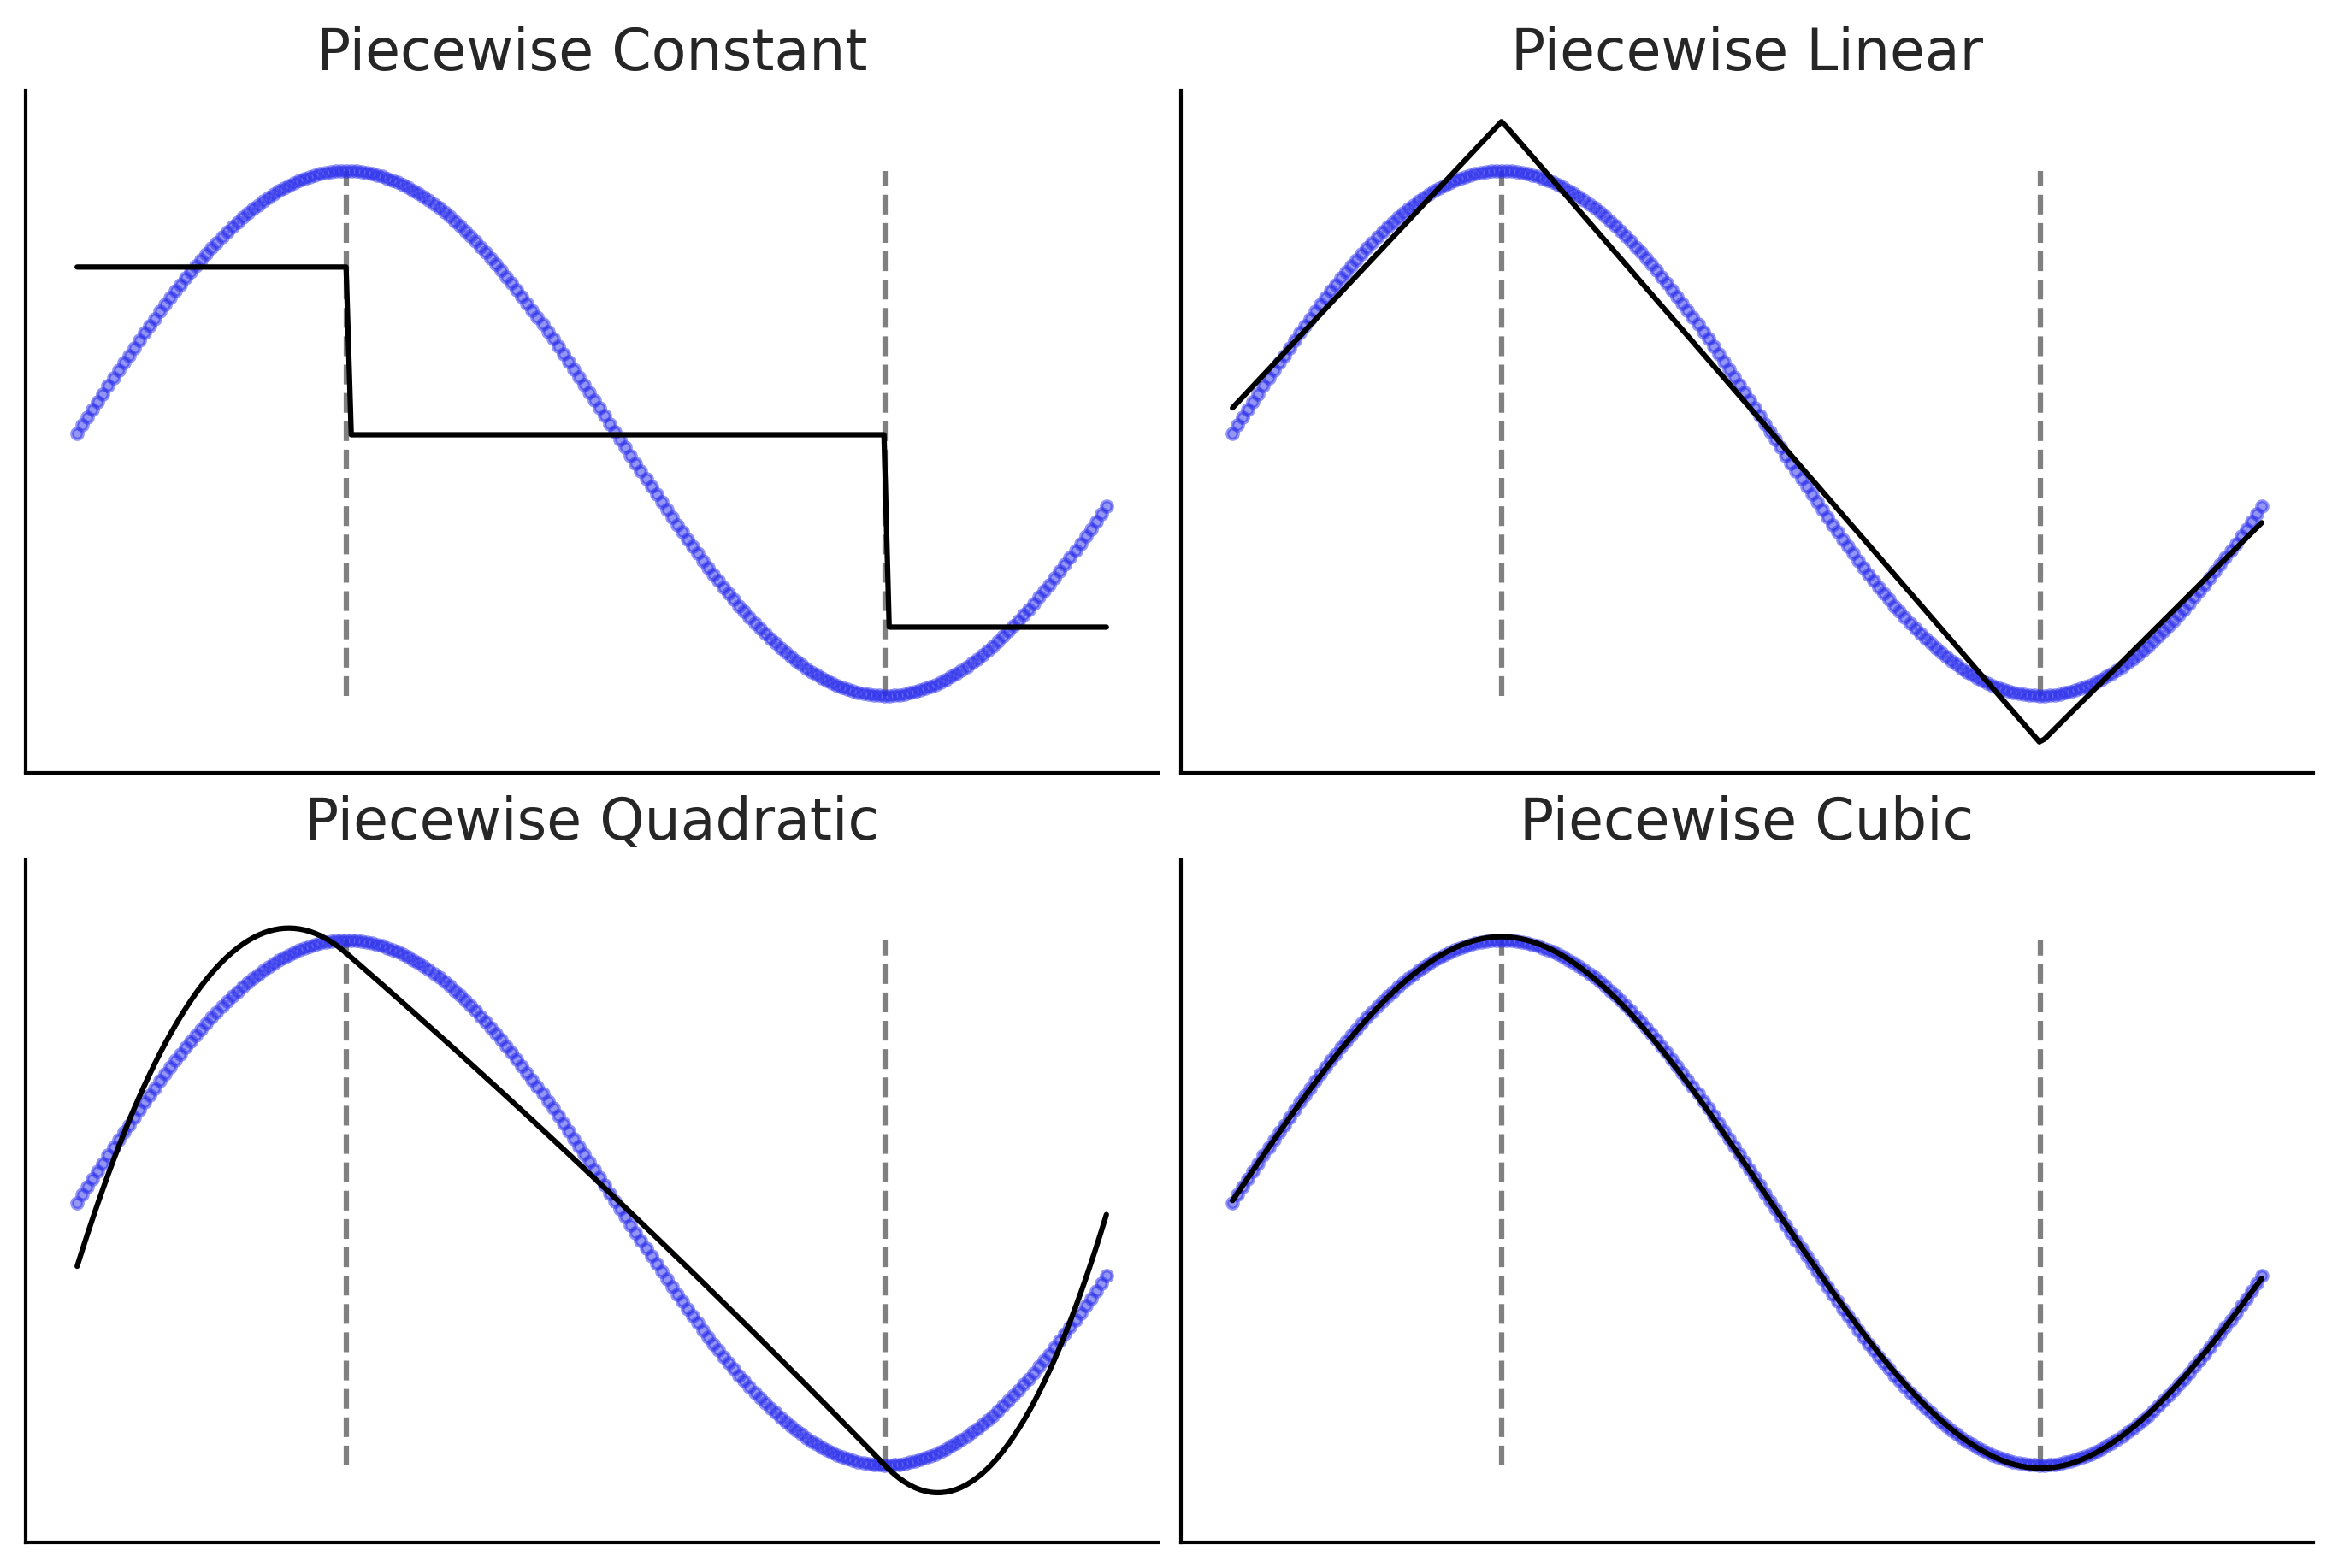

In [5]:
splines([1.57, 4.71])

In the four panels in {numref}`fig:piecewise` the goal is the same, to
approximate the blue function. We proceed by first splitting the
function into 3 subdomains, delimited by the gray dashed lines, and then
we fit a different function to each subdomain. In the first subpanel
(piecewise constant) we fit a constant function. We can think of a
constant function as a zero degree polynomial. The aggregated solution,
i.e. the 3 segments in black is known as a **step-function**. This may
seem to be a rather crude approximation but it may be all that we need.
For example, step-functions may be OK if we are trying to find out a
discontinuous outcome like the expected mean temperature during morning,
afternoon, and night. Or when we are OK about getting a non-smooth
approximation even if we think the outcome is smooth [^3].

In the second panel (piecewise linear) we do the same as in the first
but instead of a constant function we use a linear function, which is a
first degree polynomial. Notice that the contiguous linear solutions
meet at the dashed lines, this is done on purpose. We could justify this
restriction as trying to make the solution as smooth as possible [^4].

In the third panel (piecewise quadratic) and fourth panel (piecewise
cubic) we use quadratic and cubic piecewise polynomials. As we can see
by increasing the degree of the piecewise polynomials we get further and
further flexible solutions, which brings better fits but also a higher
chance of overfitting.

Because the final fit is a function $f$ constructed from local solutions
(the $B_i$ basis functions) we can more easily accommodate the
flexibility of the model to the demands of the data at different
regions. In this particular case, we can use a simpler function
(polynomial with lower degree) to fit the data at different regions,
while providing a good overall model fit to the whole domain of the
data.

So far we have assumed we have a single predictor $X$, but the same idea
can be extended to more than one predictor $X_0, X_1, \cdots, X_p$. And
we can even add an inverse link function $\phi$ [^5] models of this form
are known as Generalized Additive Models (GAM):
{cite:p}`GelmanBayesianDataAnalysis2013, WoodGeneralizedAdditiveModels2017`.

```{math} 
:label: eq:GAM
\mathbb{E}[Y]= \phi \left(\sum_i^p f(X_i)\right)

```

Recapitulating what we learn in this section, the $B_i$ functions in
Equation {eq}`eq:bfr` are a clever statistical device that allows us to
fit more flexible models. In principle we are free to choose arbitrary
$B_i$ functions, and we may do it based on our domain knowledge, as a
result of an exploratory data analysis phase, or even by trial and
error. As not all transformations will have the same statistical
properties, it would be nice to have access to some *default* functions
with good general properties over a wider range of datasets. Starting in
the next section and for the remainder of this chapter we will restrict
the discussion to a family of basis functions known as B-splines [^6].

[^3]: In Chapter [7](chap6) we explore how step-functions have a
    central role in Bayesian Additive Regression Trees.

[^4]: This can also be justified numerically as this reduces the number
    of coefficients we need to find to compute a solution.

[^5]: As usual the identity function is a valid choice.

[^6]: Other basis functions could be wavelets or Fourier series as we
    will see in Chapter [6](chap4).

## 5.3 Introducing Splines

Splines can be seen as an attempt to use the flexibility of polynomials
but keeping them under control and thus obtaining a model with overall
good statistical properties. To define a spline we need to define knots
[^7]. The purpose of the knots is to split the domain of the variable
$\boldsymbol{X}$ into contiguous intervals. For example, the dashed
vertical gray lines in {numref}`fig:piecewise` represent knots. For our
purposes a spline is a piecewise polynomial constrained to be
continuous, that is we enforce two contiguous sub-polynomials to meet at
the knots. If the sub-polynomials are of degree $n$ we say the spline is
of degree $n$. Sometimes splines are referred to by their order which
would be $n+1$.

In {numref}`fig:piecewise` we can see that as we increase the order of
the piecewise polynomial the *smoothness* of the resulting function also
increases. As we already mentioned the sub-polynomials should meet at
the knots. On the first panel it may seem we are cheating as there is a
step, also known as a discontinuity, between each line, but this is the
best we can do if we use constant values at each interval.

When talking about splines, the sub-polynomials are formally known as
basis splines or B-splines for short. Any spline function of a given
degree can be constructed as a linear combination of basis splines of
that degree. {numref}`fig:splines_basis` shows examples of B-splines of
increasing degree from 0 to 3 (top to bottom), the dots at the bottom
represent the knots, the blue ones mark the interval at which the
highlighted B-spline (in black continuous line) is not zero. All other
B-splines are represented with a thinner dashed line for clarity, but
all B-splines are equally important. In fact, each subplots in
{numref}`fig:splines_basis` is showing all the B-splines as defined by
the given knots. In other words B-splines are completely defined by a
set of knots and a degree.

```{figure} figures/splines_basis.png
:name: fig:splines_basis
:width: 8.00in
B-splines of increasing degree, from 0 to 3. On the top subplot we have
a step function, on second a triangular function and then increasingly
Gaussian-like functions. The *stacked* knots at the boundary (smaller
black dots) are added in order to be able to define the splines close to
the borders.
```

[^7]: Also known as break points, which is arguably a more memorable
    name, but still knots is widely used in the literature.

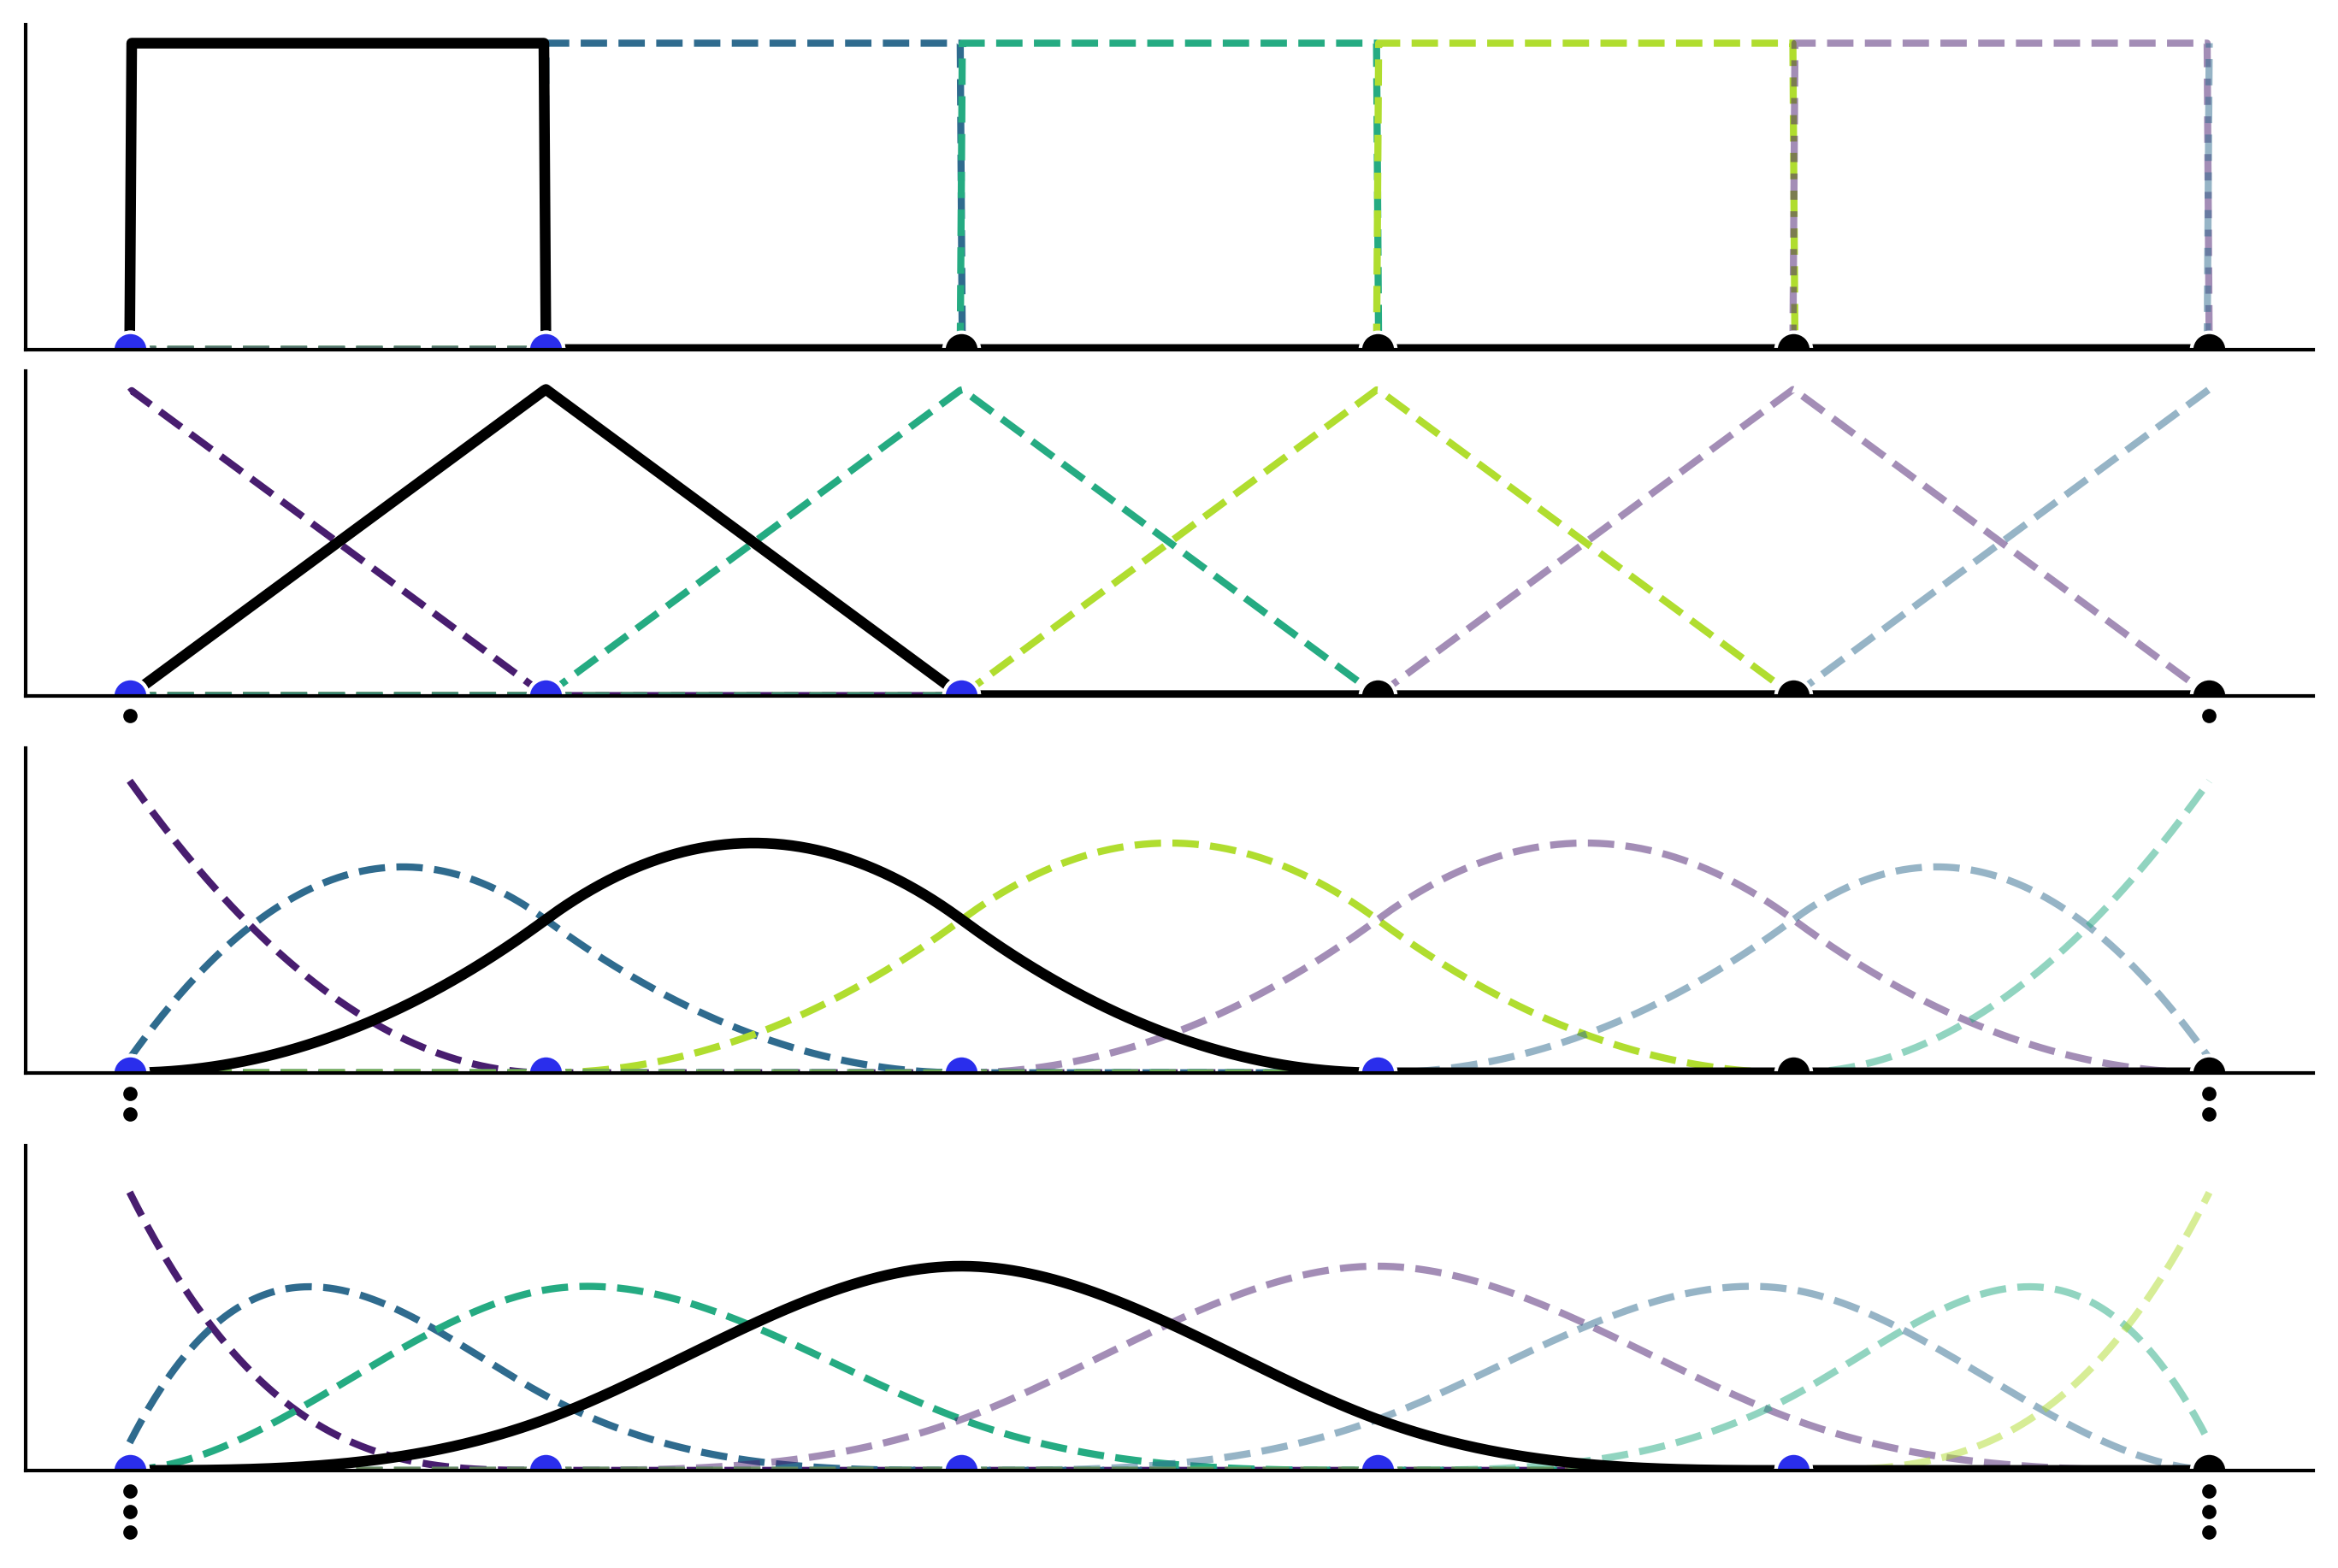

In [6]:
x = np.linspace(-0.0001, 1, 1000)
knots = [0, 0.2, 0.4, 0.6, 0.8, 1]

_, axes = plt.subplots(4, 1, figsize=(9, 6), sharex=True, sharey=True)
for deg, ax in enumerate(axes):
    b_splines = bs(x, degree=deg, knots=knots, lower_bound=-0.01, upper_bound=1.01)
    for enu, b_s in enumerate(b_splines.T):
        ax.plot(x, b_s, color=viridish[enu], lw=2, ls="--")
    ax.plot(x, b_splines[:,deg], lw=3)
    ax.plot(knots, np.zeros_like(knots), "ko", mec="w", ms=10)
    for i in range(1, deg+1):
        ax.plot([0, 1], np.array([0, 0])-(i/15), "k.", clip_on=False)
    ax.plot(knots[:deg+2], np.zeros_like(knots[:deg+2]), "C4o", mec="w", ms=10)
plt.ylim(0)
plt.xticks([])
plt.yticks([]);
plt.savefig('img/chp05/splines_basis.png')

From {numref}`fig:splines_basis` we can see that as we increase the
degree of the B-spline, the domain of the B-spline spans more and more
[^8]. Thus, for higher degree spline to make sense we need to define
more knots. Note that in all cases B-splines are restricted to be
non-zero only inside a given interval. This property make splines
regression more *local* than what we would get from a polynomial
regression.

As the number of knots controlling each B-splines grows with the degree,
for all degrees larger than 0, we are not able to define a B-spline near
to the boundaries. This is the reason the B-spline is highlighted in
black in {numref}`fig:splines_basis` to the right as we increase the
degree. This presents a potential problem, because it leaves us with
less B-splines at the boundaries, so our approximation will suffer
there. Fortunately, this boundary problem is easy to solve, we just need
to add knots at the boundaries (see the small dots in
{numref}`fig:splines_basis`). So if our knots are (0,1,2,3,4,5) and we
want to fit a cubic spline (like in the last subplot of
{numref}`fig:splines_basis`) we will need to actually use the set of
knots (0,0,0,0,1,2,3,4,5,5,5,5). That is, we pad the 0 three times at
the beginning and we pad the 5 three times at the end. By doing so we
now have the five necessary knots (0,0,0,0,1) to define the first
B-spline (see the dashed indigo line that looks like an Exponential
distribution in the last subpanel of {numref}`fig:splines_basis`). Then
we will use the knots 0,0,0,1,2 to define the second B-spline (the one
that looks like a Beta distribution), etc. See how the first *complete*
B-splines (highlighted in black) is defined by the knots (0,1,2,3,4)
which are the knots in blue. Notice that we need to pad the knots at the
boundaries as many times as the degree of the spline. That is why we
have no extra knots for degree 0 and 6 extra knots for degree 3.

Each single B-spline is not very useful on its own, but a linear
combination of all of them allows us to fit complex functions. Thus, in
practice fitting splines requires that we choose the order of the
B-splines, the number and locations of knots and then find the set of
coefficients to weight each B-spline. This is represented in
{numref}`fig:splines_weighted`. We can see the basis functions
represented using a different color to help individualize each
individual basis function. The knots are represented with black dots at
the bottom of each subplot. The second row is more interesting as we can
see the same basis functions from the first row scaled by a set of
$\beta_i$ coefficients. The thicker continuous black line represents the
spline that is obtained by a weighted sum of the B-splines with the
weights given by the $\beta$ coefficients.

```{figure} figures/splines_weighted.png
:name: fig:splines_weighted
:width: 8.00in
B-splines defined using Patsy. On the first row we can see splines of
increasing order 1 (piecewise constant), 2 (piecewise linear) and 4
(cubic) represented with gray dashed lines. For clarity each basis
function is represented with a different color. On the second row we
have the basis splines from the first row scaled by a set of
coefficients. The thick black line represents the sum of these basis
functions. Because the value of the coefficients was randomly chosen we
can see each sub-panel in the second row as a random sample from a prior
distribution over the *spline space*.
```

[^8]: In the limit of infinite degree a B-spline will span the entire
    real line and not only that, it will converge to a Gaussian
    <https://www.youtube.com/watch/9CS7j5I6aOc>.

In [7]:
x = np.linspace(0., 1., 500)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", 
             {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1",
             {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True) - 1",
             {"x": x, "knots":knots})

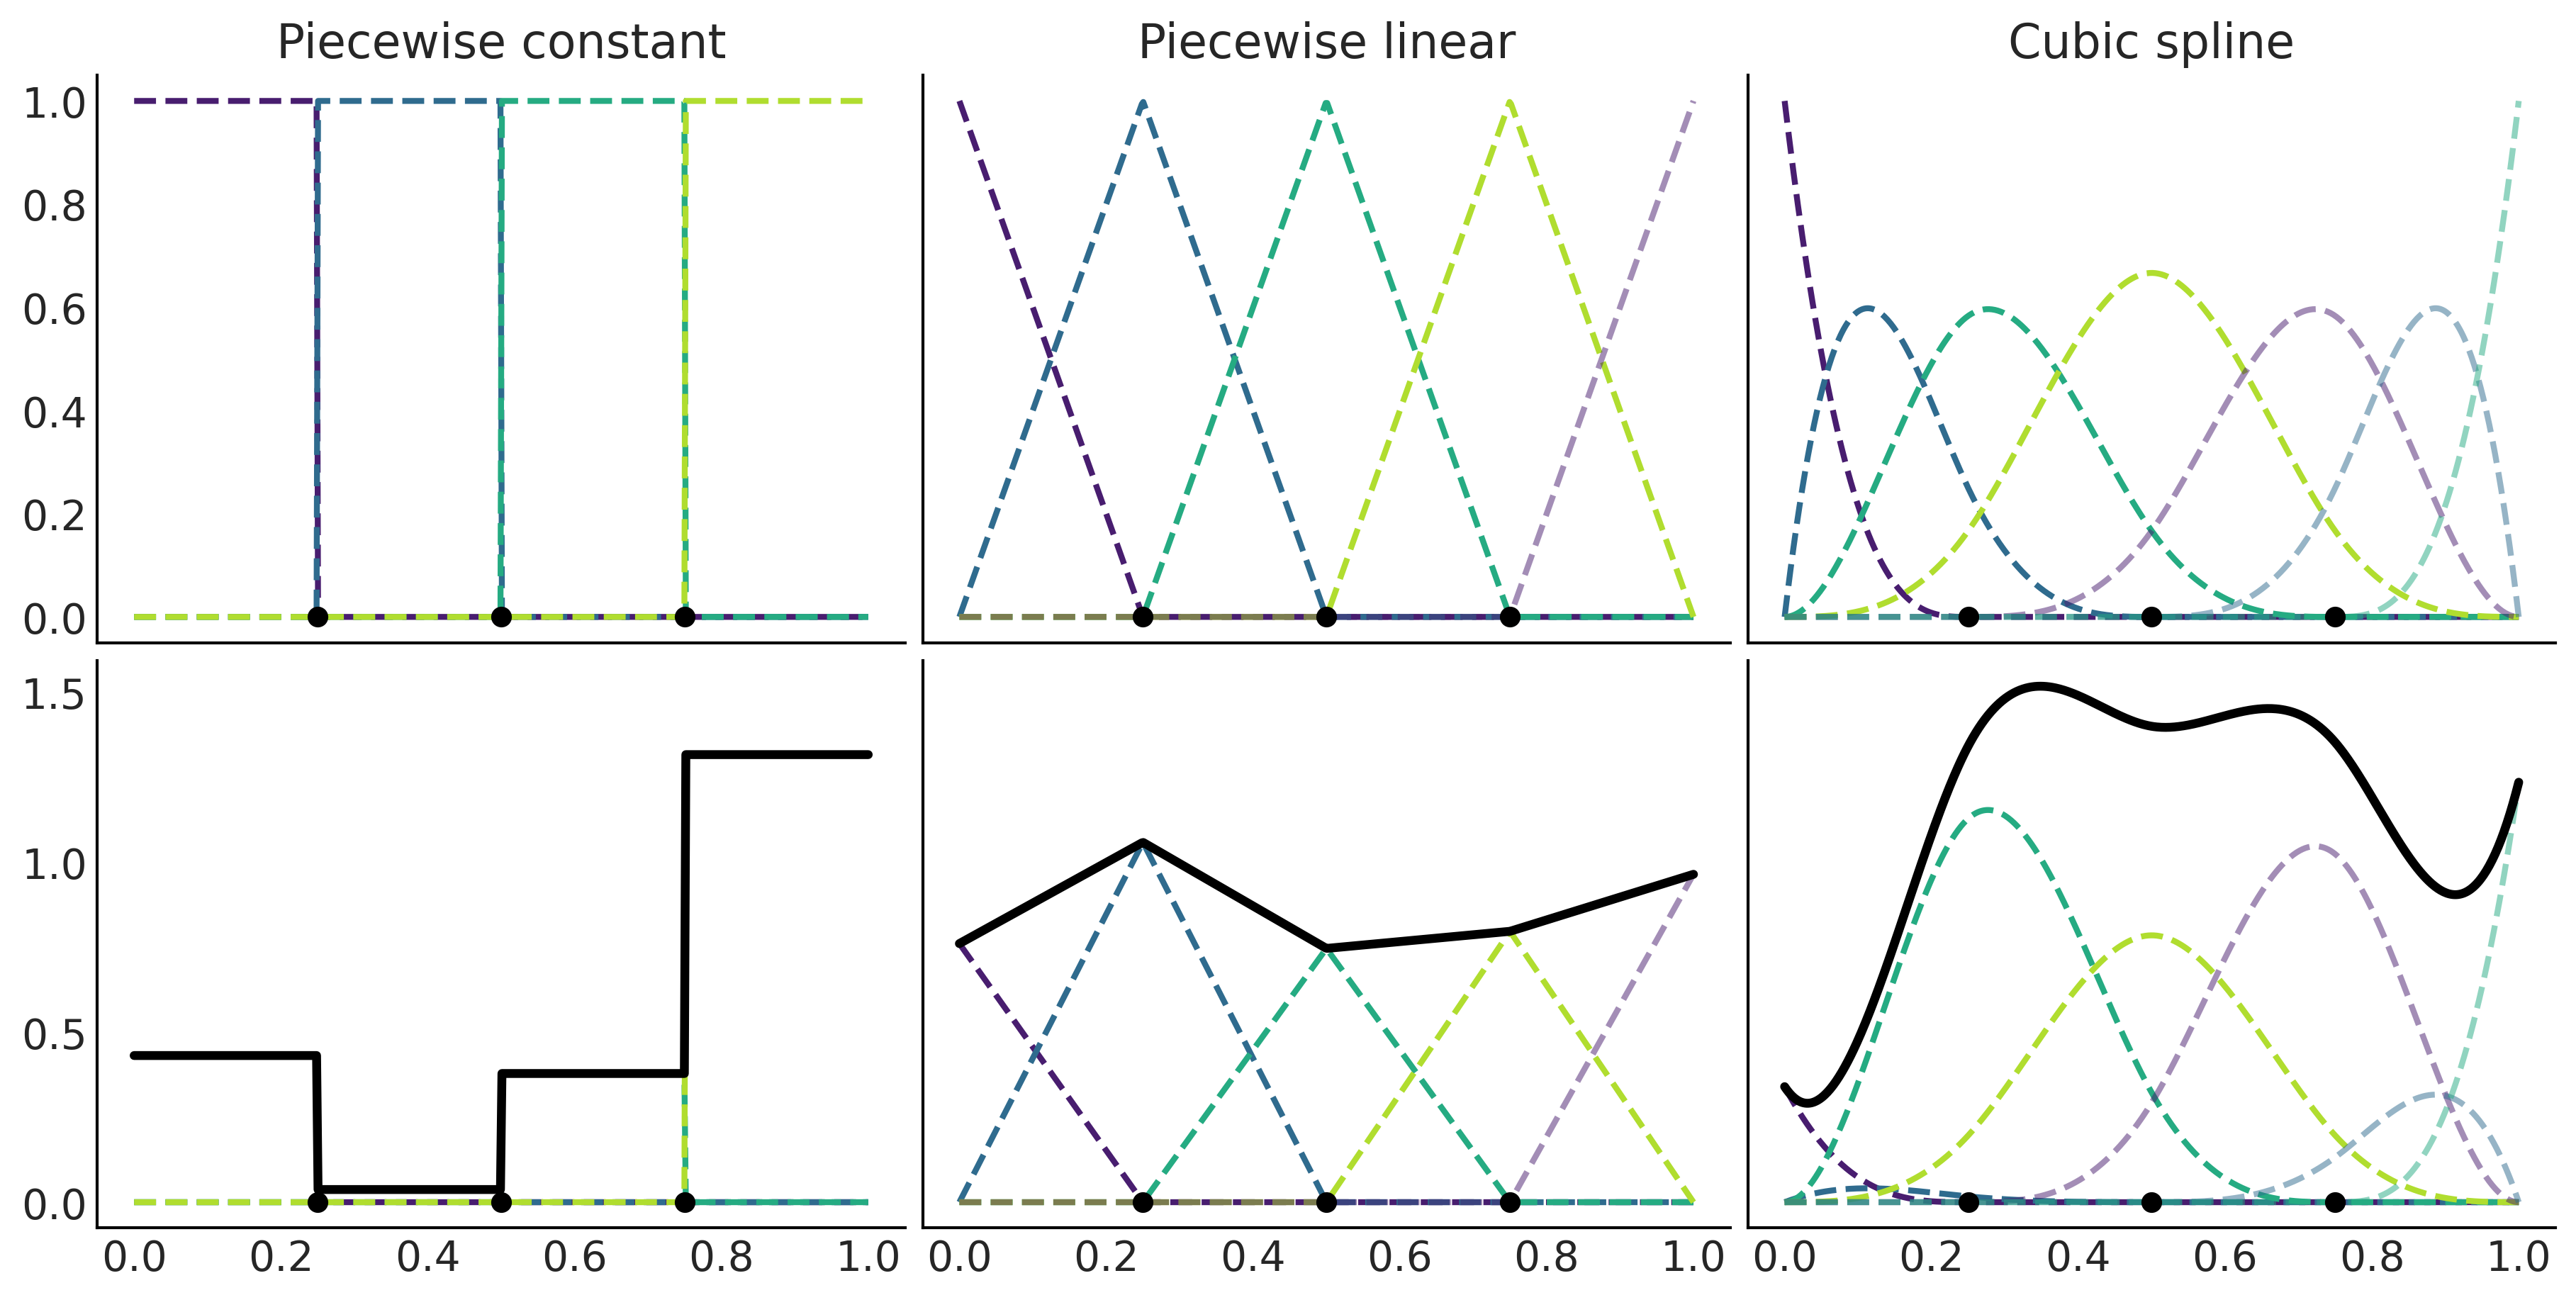

In [8]:
np.random.seed(1563)
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey='row')
for idx, (B, title) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant",
                                      "Piecewise linear",
                                      "Cubic spline"))):
    # plot spline basis functions
    for i in range(B.shape[1]):
        axes[0, idx].plot(x, B[:, i],
                          color=viridish[i], lw=2, ls="--")
    # we generate some positive random coefficients 
    # there is nothing wrong with negative values
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    # plot spline basis functions scaled by its β
    for i in range(B.shape[1]):
        axes[1, idx].plot(x, B[:, i]*β[i],
                          color=viridish[i], lw=2, ls="--")
    # plot the sum of the basis functions
    axes[1, idx].plot(x, np.dot(B, β), color='k', lw=3)
    # plot the knots
    axes[0, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[1, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[0, idx].set_title(title)

plt.savefig('img/chp05/splines_weighted.png')

In this example we generated the $\beta_i$ coefficients by sampling from
a Half Normal distribution (Line 17 in Code Block
[splines_patsy_plot](splines_patsy_plot)). Thus, each
panel in {numref}`fig:splines_weighted` is showing only one realization
of a probability distribution over splines. You can easily see this is
true by removing the random seed and running Code Block
[splines_patsy_plot](splines_patsy_plot) a few times, each
time you will see a different spline. Additionally, you may also try
replacing the Half Normal distribution, with another one like the
Normal, Exponential, etc. {numref}`fig:splines_realizations` shows four
realization of cubic splines.

```{figure} figures/splines_realizations.png
:name: fig:splines_realizations
:width: 8.00in
Four realizations of cubic splines with $\beta_i$ coefficients sampled
from a Half Normal distribution.
```

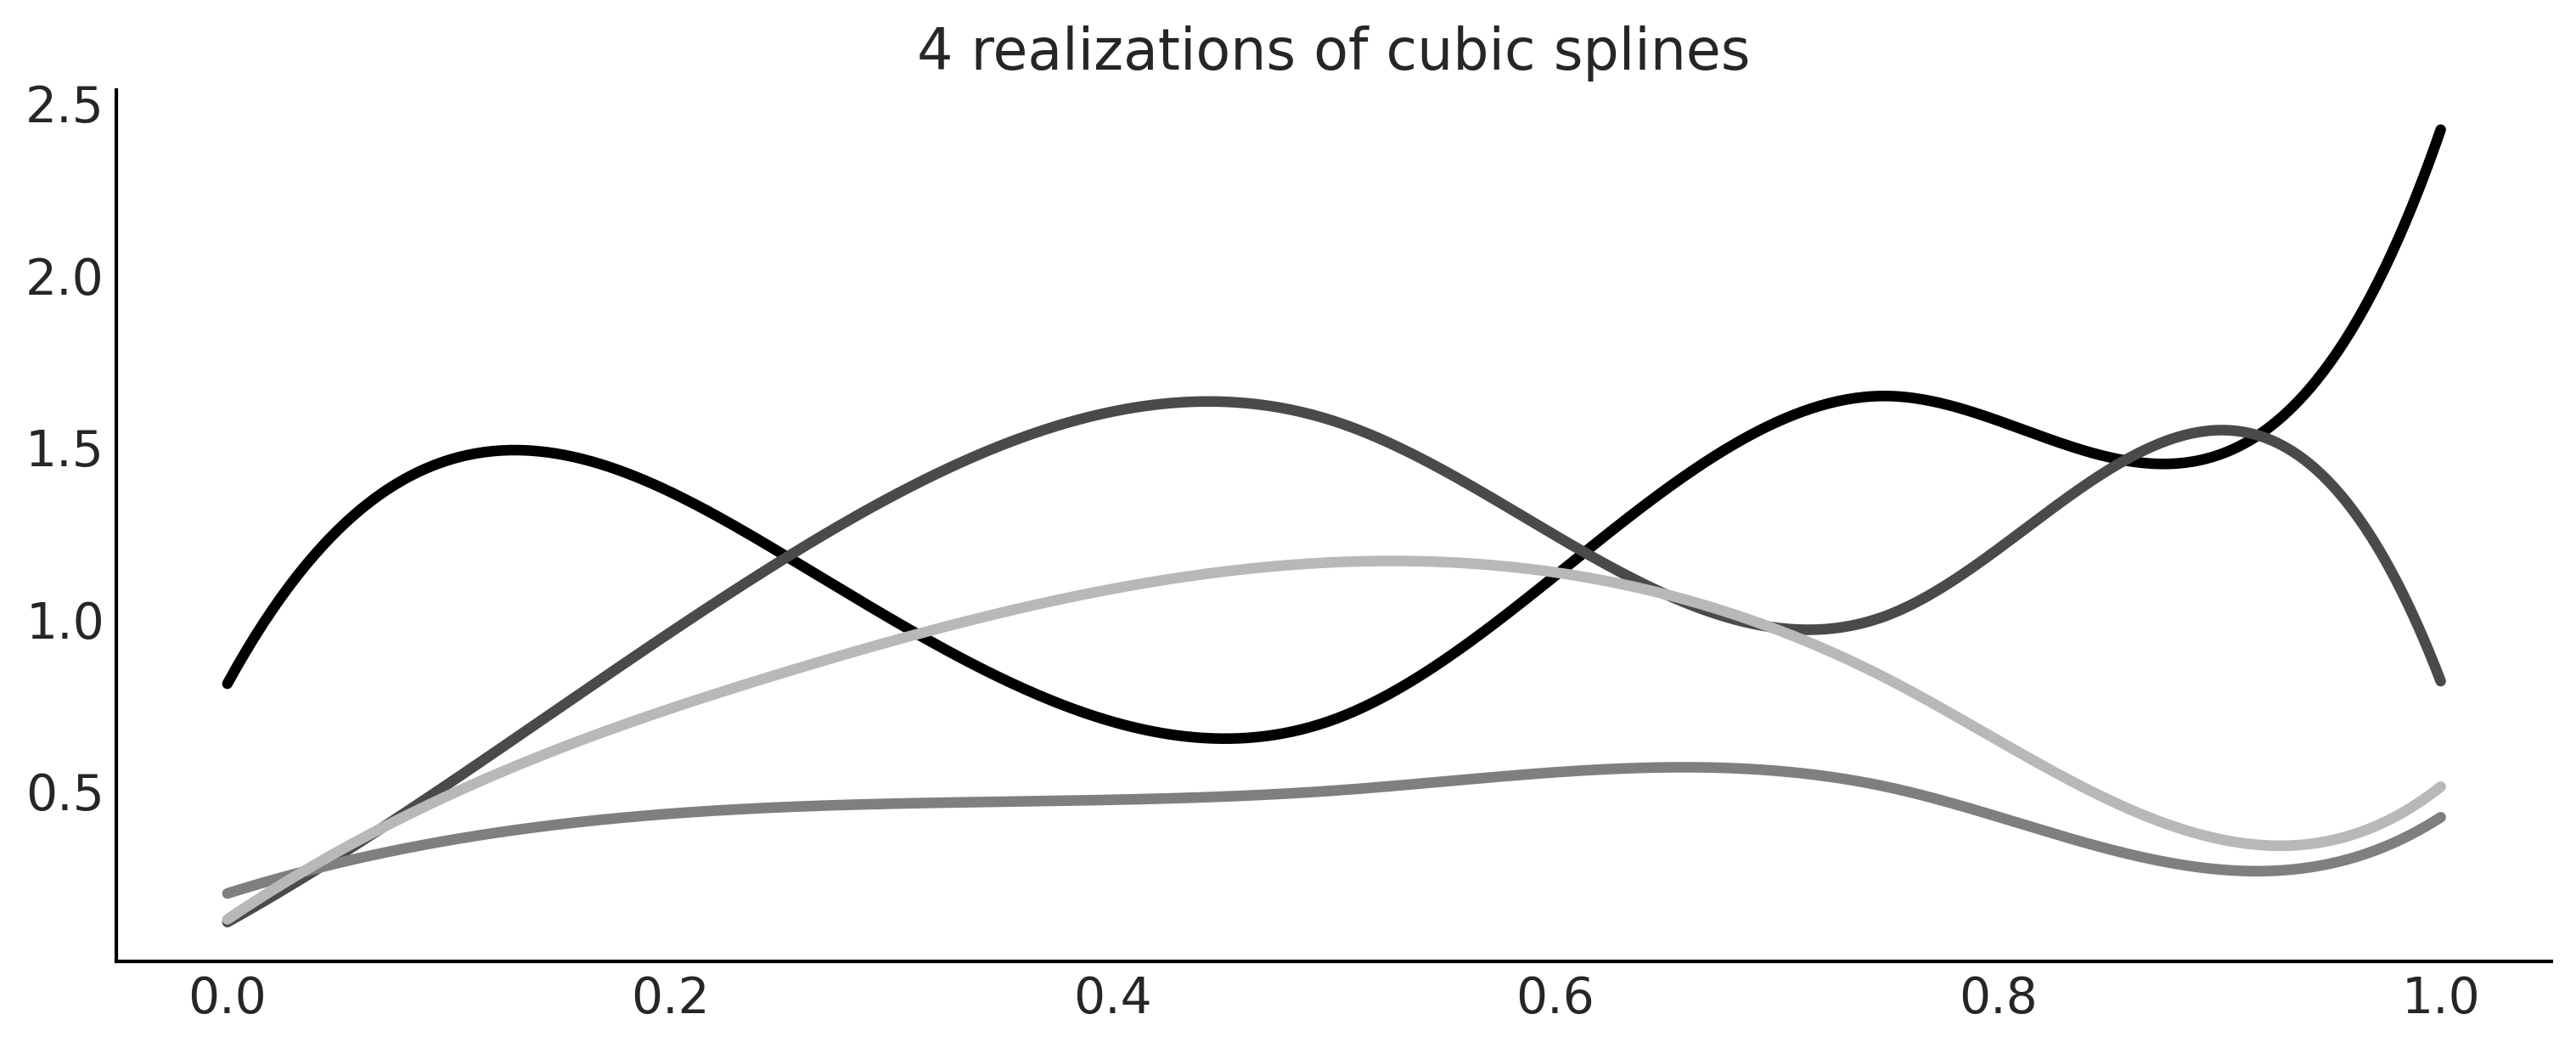

In [9]:
_, axes = plt.subplots(1, 1, figsize=(10, 4))

for i in range(4):
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    axes.plot(x, np.dot(B, β), color=f'C{i}', lw=3)
    axes.set_title("4 realizations of cubic splines")

plt.savefig('img/chp05/splines_realizations.png')

::: {admonition} Four is a crowd for splines

Of all possible splines, probably cubic splines are the most commonly used.
But why are cubic splines the queen
of splines? Figures {numref}`fig:piecewise` and
{numref}`fig:splines_weighted` offer some hints. Cubic splines provide
us with the lowest order of splines able to generate *smooth enough*
curves for most common scenarios, rendering higher order splines less
attractive. What do we mean by *smooth enough*? Without going into the
mathematical details, we meant that the fitted function does not present
sudden changes of slope. One way of doing this is by adding the
restriction that two contiguous piecewise polynomials should meet at
their common knots. Cubic splines have two additional restrictions, the
first and second derivatives are also continuous, meaning that the slope
is continuous at the knots and also the slope of the slope [^9]. In
fact, a spline of degree $m$ will have $m-1$ derivatives at the knots.
Having said all that, splines of lower or higher order can still be
useful for some problems, it is just that cubic splines are good
defaults.
:::

[^9]: Check
    <https://pclambert.net/interactivegraphs/spline_continuity/spline_continuity>
    for further intuition

## Building the Design Matrix using Patsy

In Figures {numref}`fig:splines_basis` and
{numref}`fig:splines_weighted` we plot the B-splines, but so far we have
omitted how to compute them. The main reason is that computation can be
cumbersome and there are already efficient algorithms available in
packages like Scipy [^10]. Thus, instead of discussing how the B-splines
can be computed from scratch we are going to rely on Patsy, a package
for describing statistical models, especially linear models, or models
that have a linear component, and building design matrices. It is
closely inspired by the *formula mini-language* widely used in many
packages from the R programming language ecosystem. Just for you to get
a taste of the formula language, a linear model with two covariates
looks like `"y ~ x1 + x2"` and if we want to add an interaction we can
write `"y ~ x1 + x2 + x1:x2"`. This is a similar syntax as the one shown
in Chapter [3](chap2) in the box highlighting Bambi. For more
details please check the patsy documentation [^11].

To define a basis spline design matrix in Patsy we need to pass a string
to the `dmatrix` function starting with the *particle* `bs()`, while
this particle is a string is parsed by Patsy as a function. And thus it
can also take several arguments including the data, an array-like of
knots indicating their location and the degree of the spline. In Code
Block [splines_patsy](splines_patsy) we define 3 design
matrices, one with degree 0 (piecewise constant), another with degree 1
(piecewise linear) and finally one with degree 3 (cubic spline).

```{code-block} python
:name: splines_patsy
:caption: splines_patsy

x = np.linspace(0., 1., 500)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", 
             {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1",
             {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True) - 1",
             {"x": x, "knots":knots})
```

{numref}`fig:design_matrices` represents the 3 design matrices computed
with Code Block [splines_patsy](splines_patsy). To better
grasp what Patsy is doing we also recommend you use Jupyter notebook/lab
or your favorite IDE to inspect the objects `B0`, `B1` and `B2`.

```{figure} figures/design_matrices.png
:name: fig:design_matrices
:width: 8.00in
Design matrices generated with Patsy in Code Block
[splines_patsy](splines_patsy). The color goes from black
(1) to light-gray (0), the number of columns is the number of B-splines
and the number of rows the number of datapoints.
```

[^10]: If interested you can check
    <https://en.wikipedia.org/wiki/De_Boor's_algorithm>.

[^11]: <https://patsy.readthedocs.io>

In [10]:
x = np.linspace(0., 1., 20)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1", {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) - 1", {"x": x, "knots":knots})

The first subplot of {numref}`fig:design_matrices` corresponds to `B0`,
a spline of degree 0. We can see that the design matrix is a matrix with
only zeros (light-gray) and ones (black). The first B-spline (column 0)
is 1 for the first 5 observations and 0 otherwise, the second B-spline
(column 1) is 0 for the first 5 observations, 1 for the second 5
observations and 0 again. And the same pattern is repeated. Compare this
with the first subplot (first row) of {numref}`fig:splines_weighted`,
you should see how the design matrix is encoding that plot.

For the second subplot in {numref}`fig:design_matrices` we have the
first B-spline going from 1 to 0, the second, third and fourth goes from
0 to 1 and then back from 1 to 0. The fifth B-spline goes from 0 to 1.
You should see how this patterns match the line with negative slope, the
3 triangular functions and the line with positive slope in the second
subplot (first row) of {numref}`fig:splines_weighted`.

Finally we can see something similar if we compare how the 7 columns in
the third subplot in {numref}`fig:design_matrices` match the 7 curves in
the third subplot (first row) of {numref}`fig:splines_weighted`.

Code Block [splines_patsy](splines_patsy) was used to
generate the B-splines in Figures {numref}`fig:splines_weighted` and
{numref}`fig:design_matrices`, the only different is that for the former
we used `x = np.linspace(0., 1., 500)`, so the curves look smoother and
we use `x = np.linspace(0., 1., 20)` in the later so the matrices are
easier to understand.

```{code-block} python
:name: splines_patsy_plot
:caption: splines_patsy_plot

_, axes = plt.subplots(2, 3, sharex=True, sharey="row")
for idx, (B, title) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant",
                                      "Piecewise linear",
                                      "Cubic spline"))):
    # plot spline basis functions
    for i in range(B.shape[1]):
        axes[0, idx].plot(x, B[:, i],
                          color=viridish[i], lw=2, ls="--")
    # we generate some positive random coefficients 
    # there is nothing wrong with negative values
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    # plot spline basis functions scaled by its β
    for i in range(B.shape[1]):
        axes[1, idx].plot(x, B[:, i]*β[i],
                          color=viridish[i], lw=2, ls="--")
    # plot the sum of the basis functions
    axes[1, idx].plot(x, np.dot(B, β), color="k", lw=3)
    # plot the knots
    axes[0, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[1, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[0, idx].set_title(title)
```

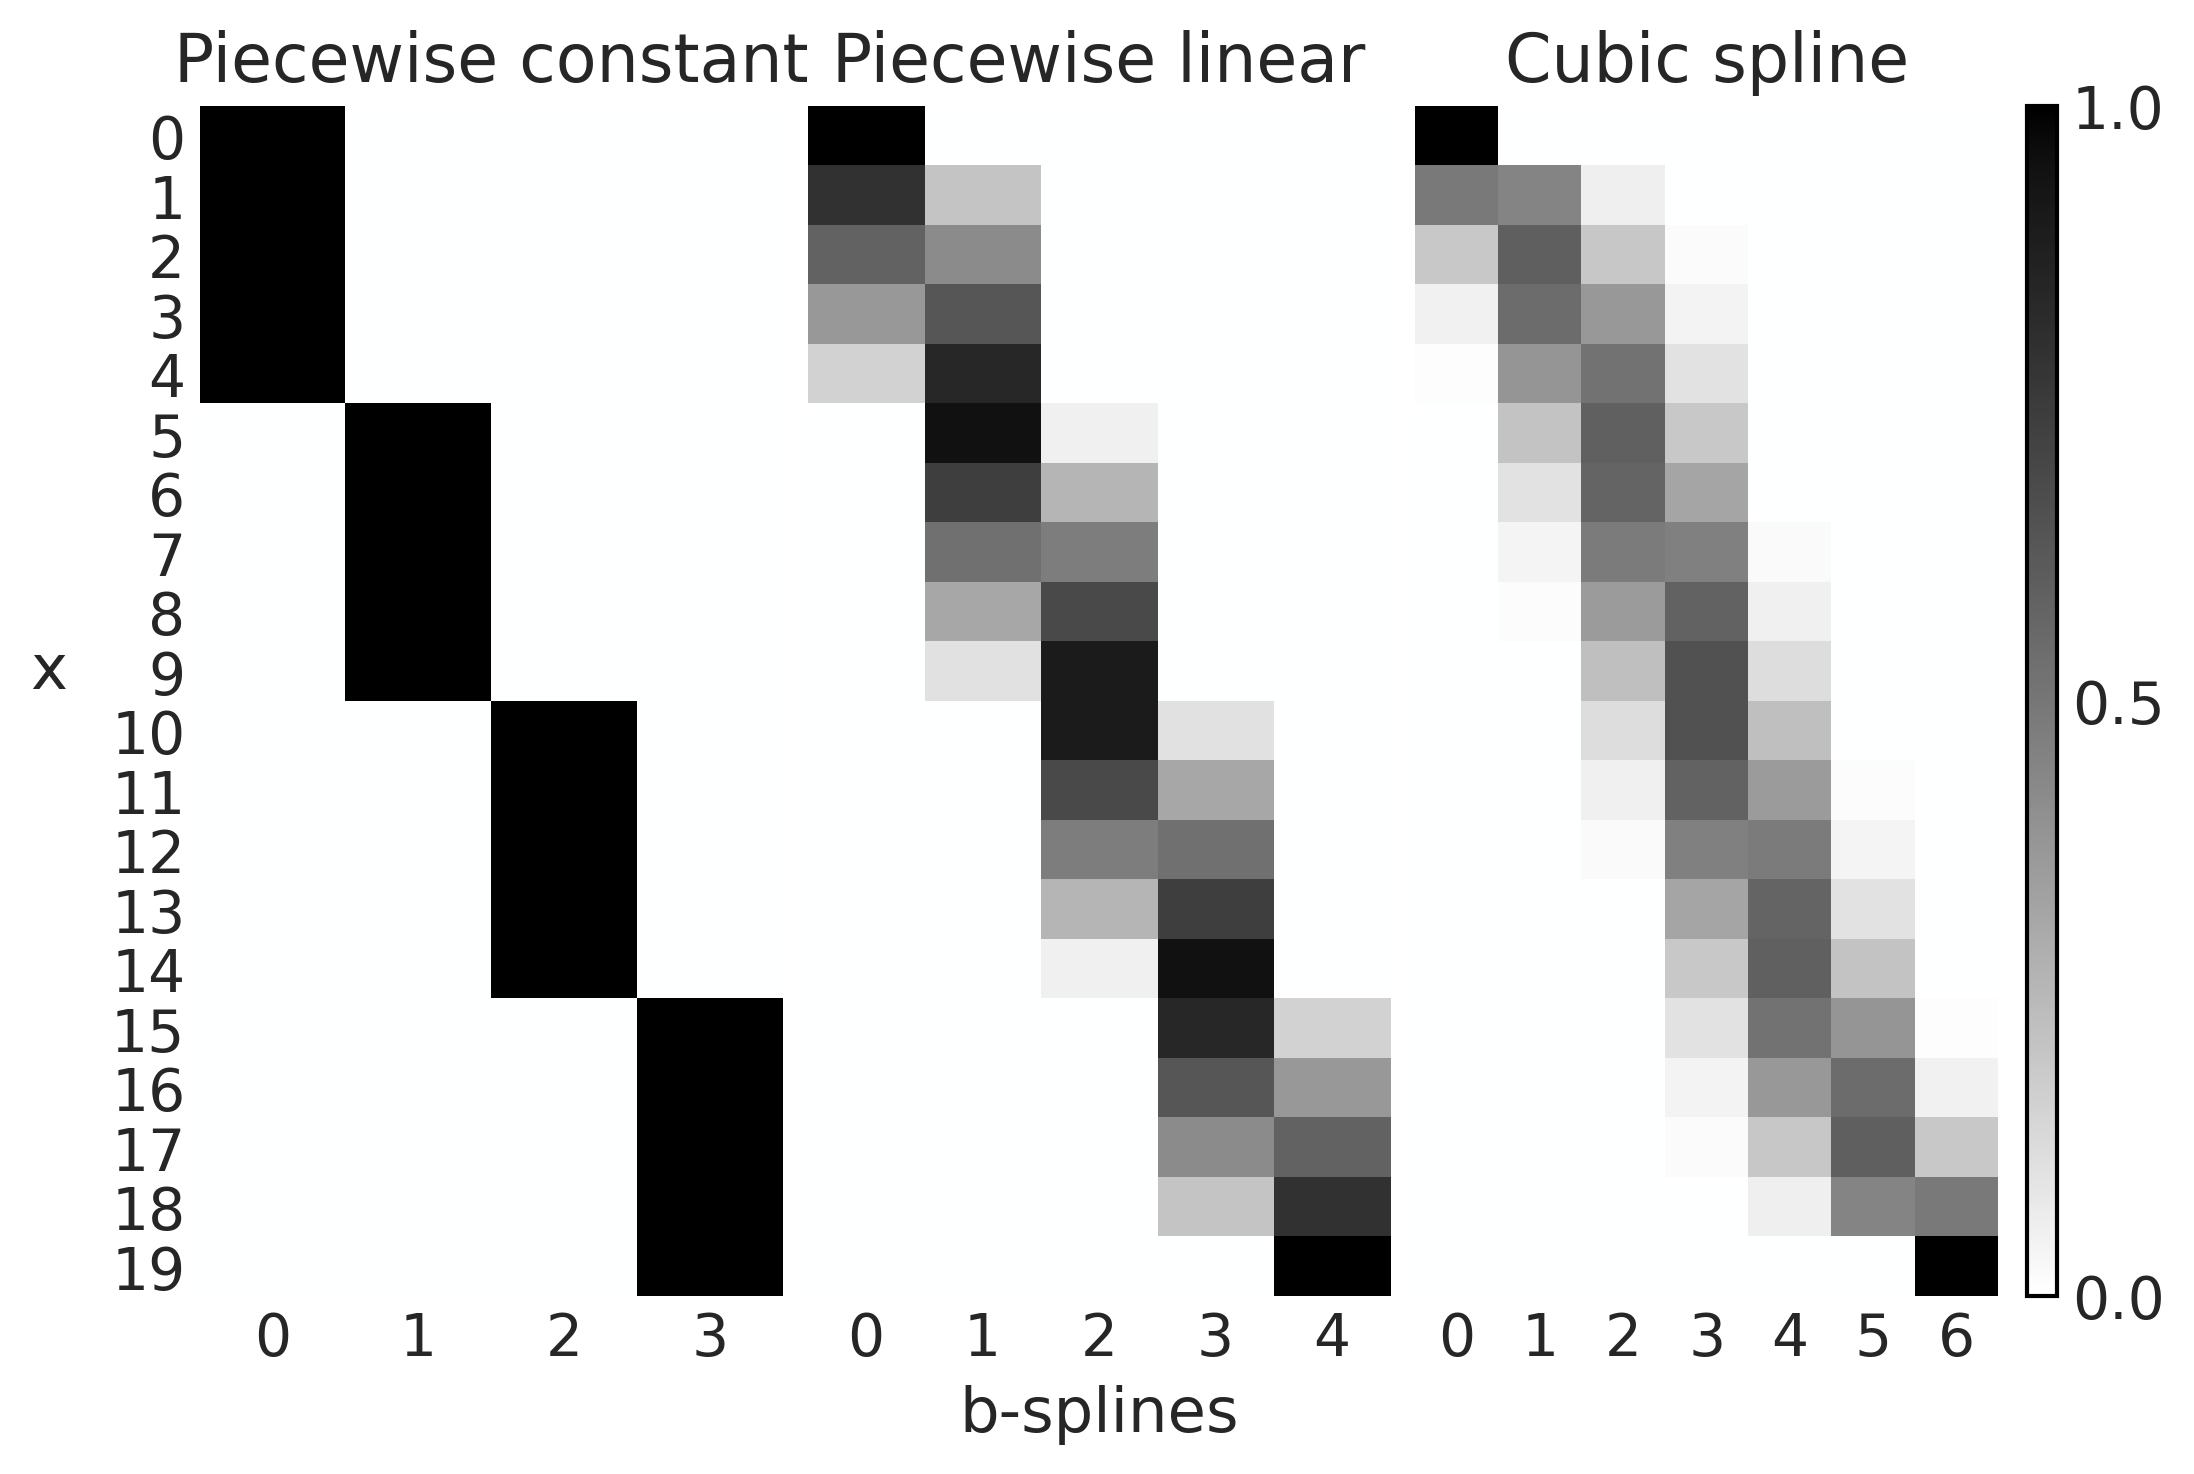

In [11]:
fig, axes = plt.subplots(1, 3, sharey=True)
for idx, (B, title, ax) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant", 
                                      "Piecewise linear", 
                                      "Cubic spline"),
                                      axes)):
    cax = ax.imshow(B, cmap="cet_gray_r", aspect="auto")
    ax.set_xticks(np.arange(B.shape[1]))
    ax.set_yticks(np.arange(B.shape[0]))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)


axes[1].set_xlabel("b-splines")
axes[0].set_ylabel("x", rotation=0, labelpad=15)
fig.colorbar(cax, aspect=40, ticks=[0, 0.5, 1])
plt.savefig('img/chp05/design_matrices.png')

So far we have explored a couple of examples to gain intuition into what
splines are and how to automate their creation with the help of Patsy.
We can now move forward into computing the weights. Let us see how we
can do that in a Bayesian model with PyMC3.

(fitting-splines-in-pymc3)=

## 5.3 Fitting Splines in PyMC3

In this section we are going to use PyMC3 to obtain the values of the
regression coefficients $\beta$ by fitting a set of B-splines to the
data.

Modern bike sharing systems allow people in many cities around the globe
to rent and return bikes in a completely automated fashion, helping to
increase the efficiency of the public transportation and probably making
part of the society healthier and even happier. We are going to use a
dataset from such a bike sharing system from the University of
California Irvine's Machine Learning Repository [^12]. For our example
we are going to estimate the number of rental bikes rented per hour over
a 24 hour period. Let us load and plot the data:

```python
data = pd.read_csv("../data/bikes_hour.csv")
data.sort_values(by="hour", inplace=True)

# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]
```

```{figure} figures/bikes_data.png
:name: fig:bikes_data
:width: 8.00in
A visualization of the bikes data. Each point is the normalized number
of bikes rented per hour of the day (on the interval 0, 23). The
points are semi-transparent to avoid excessive overlapping of points and
thus help see the distribution of the data.
```

[^12]: <https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset>

In [12]:
data = pd.read_csv("../data/bikes_hour.csv")
data.sort_values(by="hour", inplace=True)

# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]

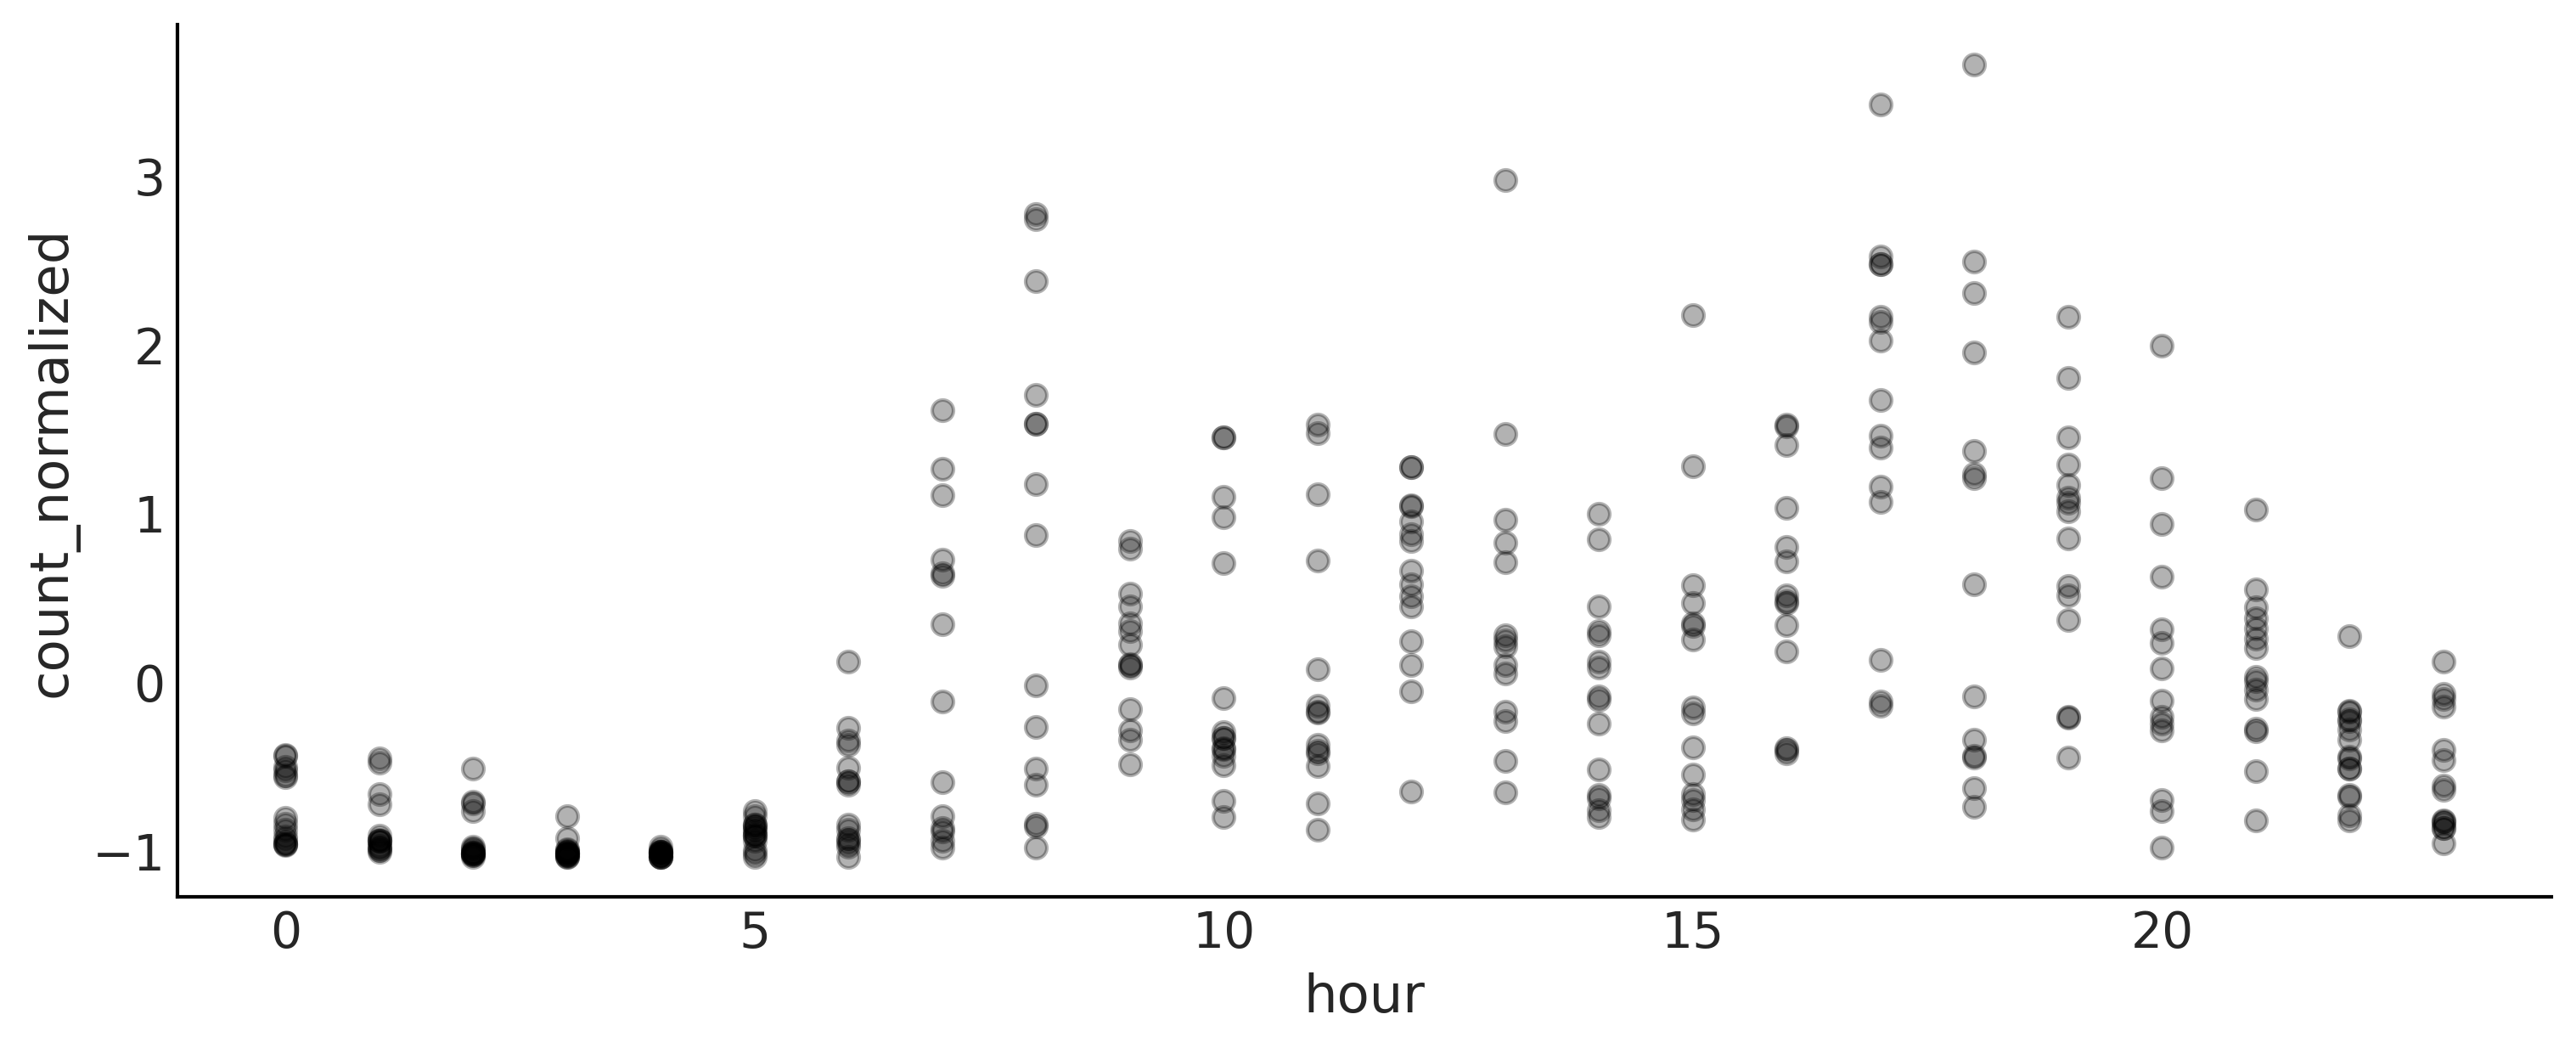

In [13]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data.count_normalized, "o", alpha=0.3)
ax.set_xlabel("hour")
ax.set_ylabel("count_normalized")
plt.savefig('img/chp05/bikes_data.png');

A quick look at {numref}`fig:bikes_data` shows that the relationship
between the hour of the day and the number of rental bikes is not going
to be very well captured by fitting a single line. So, let us try to use
a spline regression to better approximate the non-linear pattern.

As we already mentioned in order to work with splines we need to define
the number and position of the knots. We are going to use 6 knots and
use the simplest option to position them, equal spacing between each
knot.

```{code-block} python
:name: knot_list
:caption: knot_list

num_knots = 6
knot_list = np.linspace(0, 23, num_knots+2)[1:-1]
```

In [14]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]

Notice that in Code Block [knot_list](knot_list) we define
8 knots, but then we remove the first and last knots, ensuring we keep 6
knots which are defined in the *interior* of the data. Whether this is a
useful strategy will depends on the data. For example, if the bulk of
the data is away from the borders this will be a good idea, also the
larger the number of knots the less important their positions.

Now we use Patsy to define and build the design matrix for us

```{code-block} python
:name: bikes_dmatrix
:caption: bikes_dmatrix

B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list[1:-1]})
```

In [15]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

Our spline regression model is very similar to the linear models from
Chapter [3](chap2). All the hard-work is done by the design
matrix $\boldsymbol{B}$ and its expansion of the feature space. Notice
that we are using linear algebra notation to write the multiplications
and sums of Equations {eq}`eq:bfr` and {eq}`eq:bfr2` in a shorter form,
that is we write $\boldsymbol{\mu} = \boldsymbol{B}\boldsymbol{\beta}$
instead of $\boldsymbol{\mu} = \sum_i^n B_i \boldsymbol{\beta}_i$.

As usual the statistical syntax is translated into PyMC3 in nearly a
one-to-one fashion.

```{code-block} python
:name: splines
:caption: splines
with pm.Model() as splines:
    τ = pm.HalfCauchy("τ", 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(B, β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idata_s = pm.sample(1000, return_inferencedata=True)
```

We show in {numref}`fig:bikes_spline_raw_data` the final fitted linear
prediction as a solid black line and each weighted B-spline as a dashed
line. It is a nice representation as we can see how the B-splines are
contributing to the final result.

```{figure} figures/bikes_spline_raw_data.png
:name: fig:bikes_spline_raw_data
:width: 8.00in
Bikes data fitted using splines. The B-splines are represented with
dashed lines. The sum of them generates the thicker solid black line.
The plotted values correspond to mean values from the posterior. The
black dots represent the knots. The splines in this figure look very
*jagged*, relative to the splines plotted in
{numref}`fig:splines_weighted`. The reason is that we are evaluating the
function in fewer points. 24 points here because the data is binned per
hour compared to 500 in {numref}`fig:splines_weighted`.
```

In [16]:
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"])
    idata_s = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


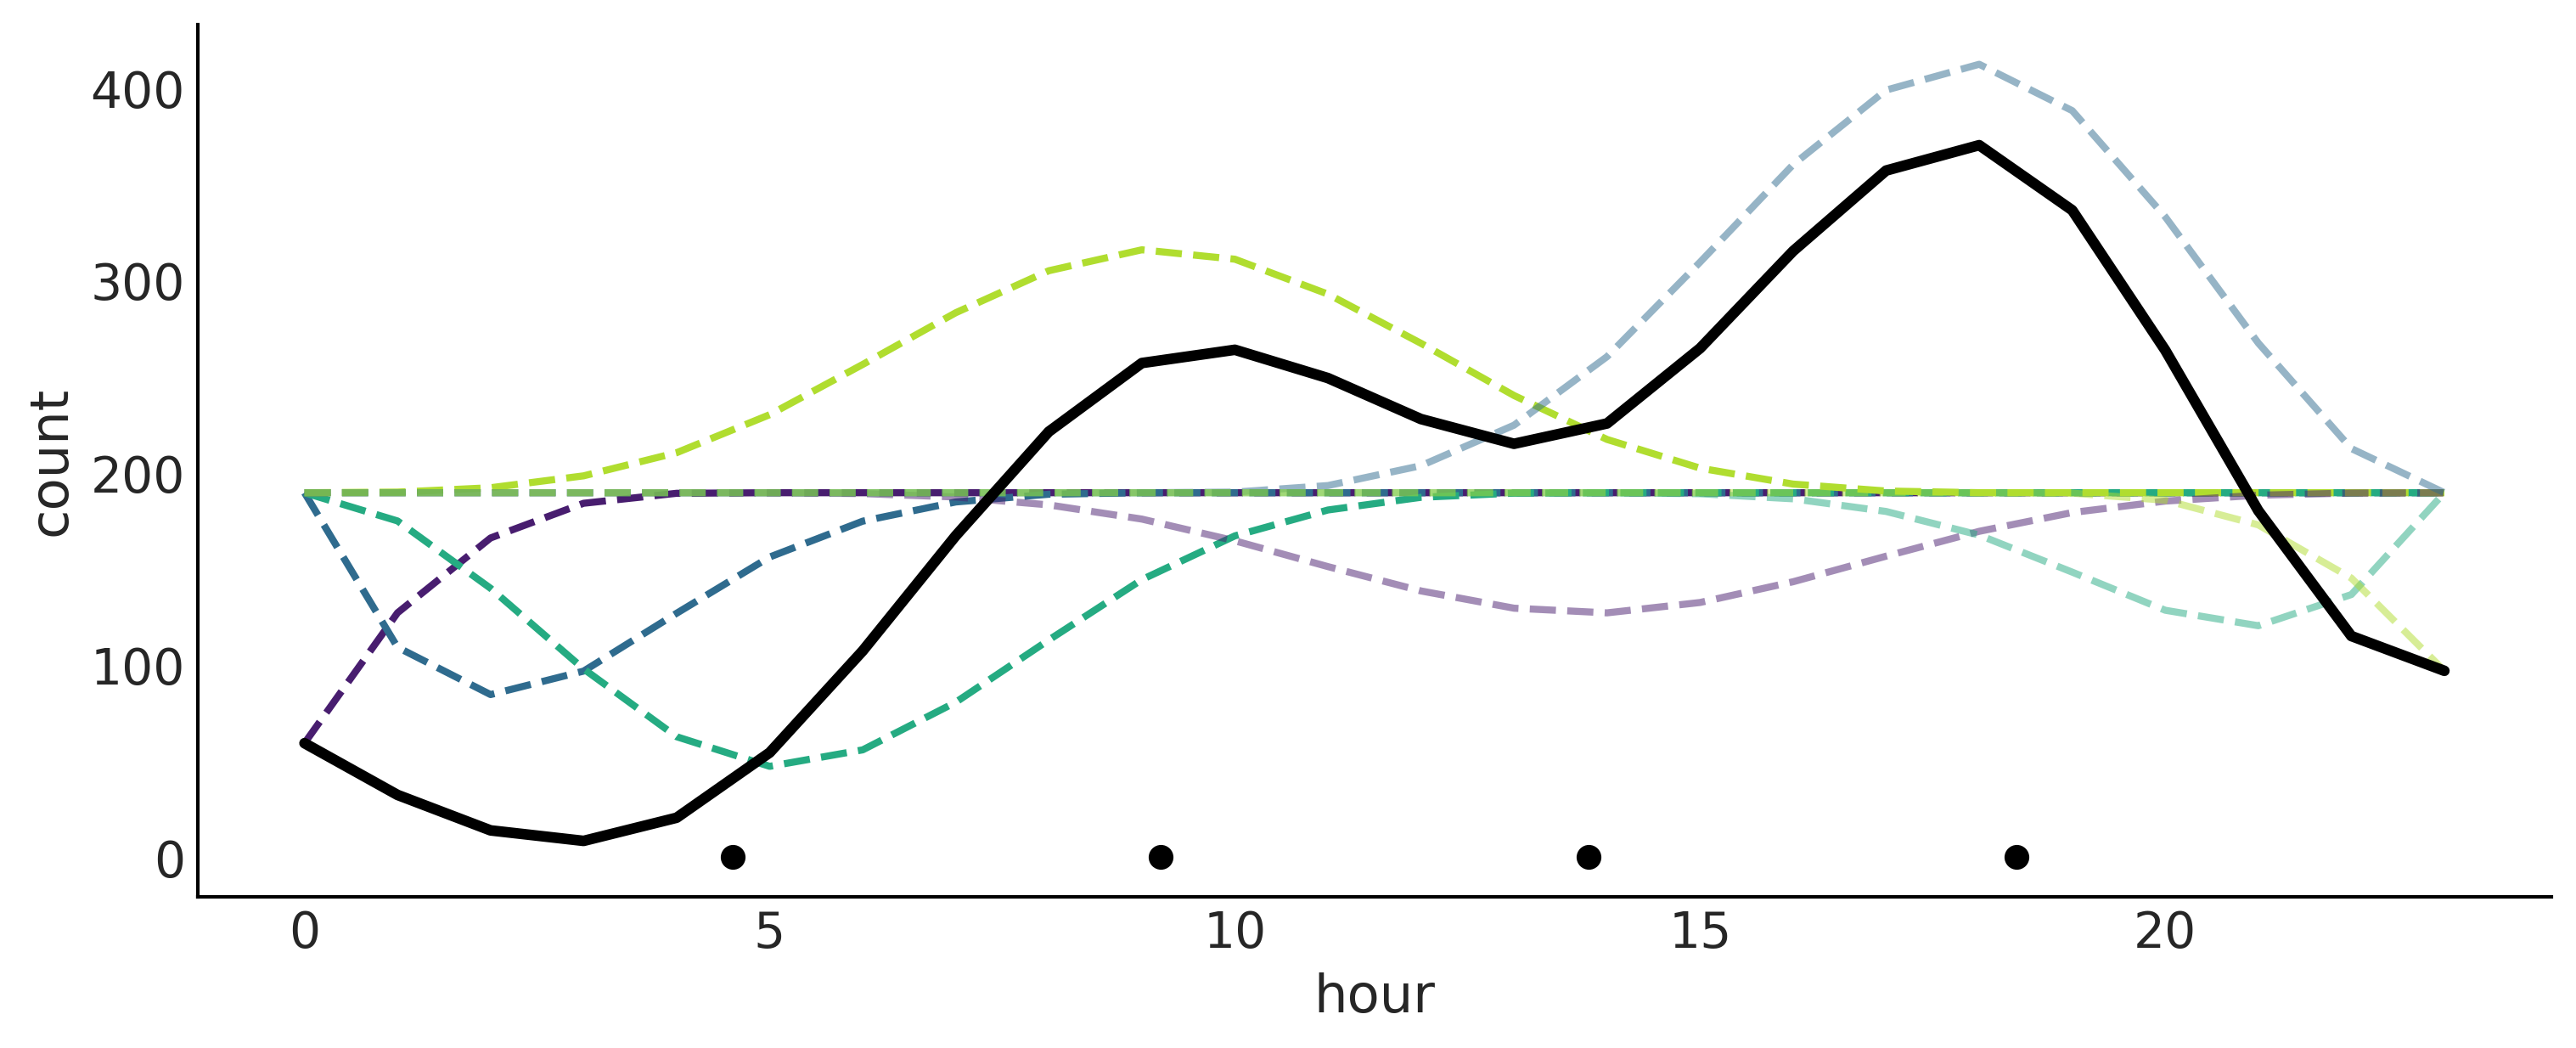

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_prop_cycle(cycler('color', viridish))
posterior = idata_s.posterior.stack(samples=['chain', 'draw'])
ax.plot(data.hour, (B*posterior["β"].mean("samples").values * data_cnt_os) + data_cnt_om, lw=2, ls='--')
ax.plot(data.hour, posterior["μ"].mean("samples") * data_cnt_os + data_cnt_om, 'k', lw=3)
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.plot(knot_list, np.zeros_like(knot_list), 'ko')
plt.savefig("img/chp05/bikes_spline_raw_data.png")

A more useful plot when we want to display the results of the model is
to plot the data with the overlaid splines and its uncertainty as in
{numref}`fig:bikes_data2`. From this figure we can easily see that the
number of rental bikes is at the lowest number late at night. There is
then an increase, probably as people wake up and go to work. We have a
first peak at around hour 10, which levels-off, or perhaps slightly
declines, then followed by a second peak as people commute back home at
around hour 18, after which there a steady decline.

```{figure} figures/bikes_spline_data.png
:name: fig:bikes_data2
:width: 8.00in
Bikes data (black dots) fitted using splines. The shaded curve
represents the 94% HDI interval (of the mean) and the blue curve
represents the mean trend.
```

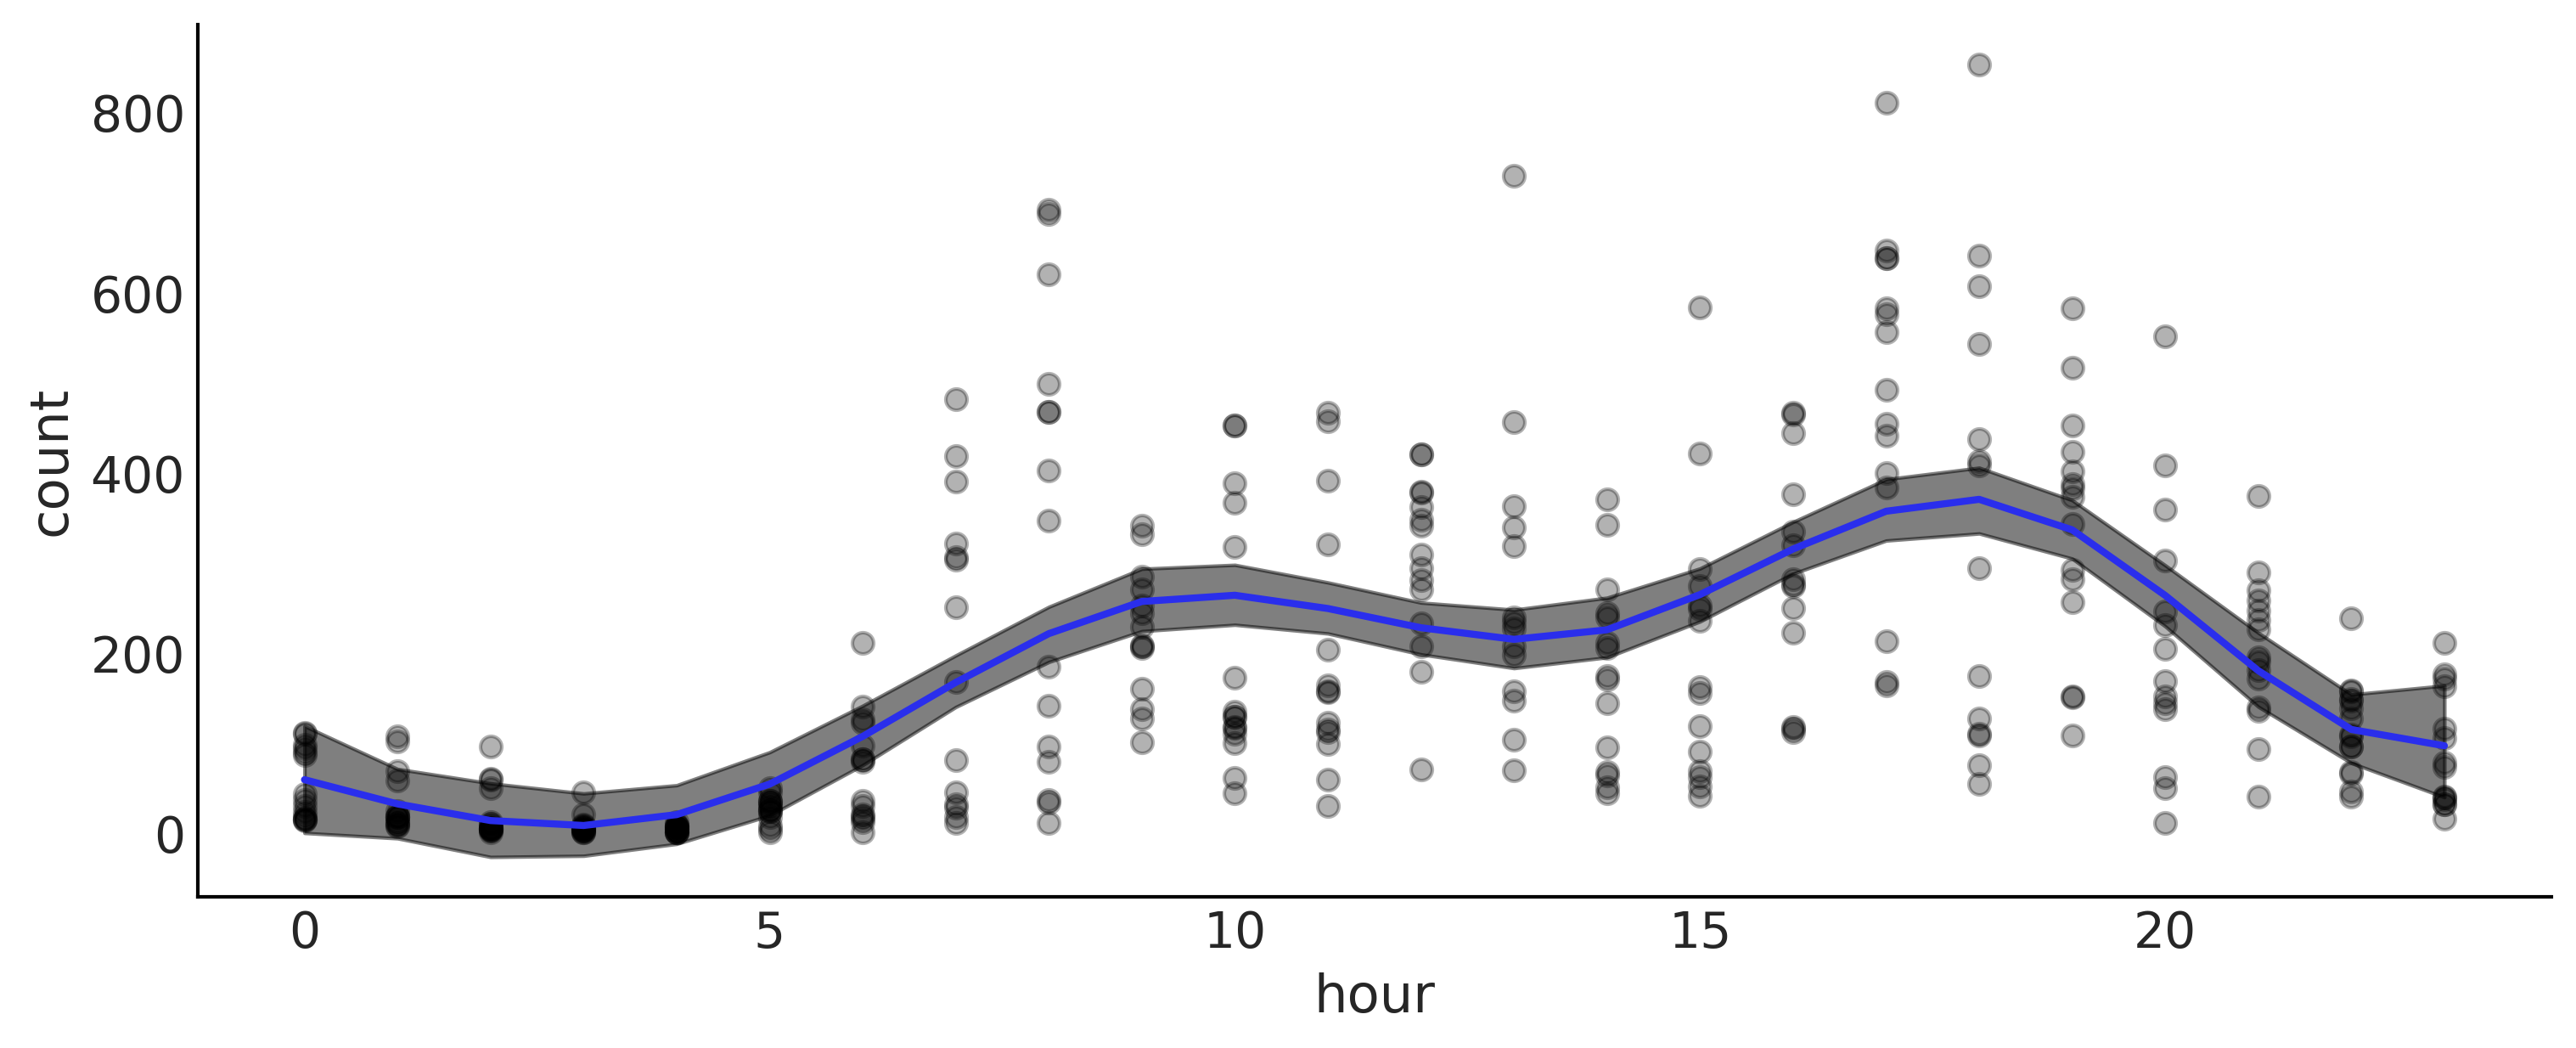

In [18]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.3, zorder=-1)
# we use data_cnt_os and data_cnt_om to rescale the cnt data and results
ax.plot(data.hour, (posterior["μ"].mean("samples")  * data_cnt_os) + data_cnt_om, color="C4", lw=2)
az.plot_hdi(data.hour, (posterior["μ"].T  * data_cnt_os) + data_cnt_om,
            color="C0", smooth=False)
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data.png")

In this bike rental example we are dealing with a circular variable,
meaning that hour 0 is equal to the hour 24. This may be more or less
obvious to us, but it is definitely not obvious to our model. Patsy
offers a simple solution to tell our model that the variable is
circular. Instead of defining the design matrix using `bs` we can use
`cc`, this is a cubic spline that is *circular-aware*. We recommend you
check the Patsy documentation for more details and explore using `cc` in
the previous model and compare results.

(choosing-knots-and-prior-for-splines)=

## 5.6 Choosing Knots and Prior for Splines

One modeling decision we have to make when working with splines is to
choose the number and location of the knots. This can be a little bit
concerning, given that in general the number of knots and their spacing
are not obvious decisions. When faced with this type of choice we can
always try to fit more than one model and then use methods such as LOO
to help us pick the best model. {numref}`tab:loo_splines` shows the
results of fitting a model like the one defined in Code Block
[splines](splines) with, 3, 6, 9, 12, and 18 equally
distanced knots. We can see that the spline with 12 knots is selected by
LOO as the best model.

One interesting observation from {numref}`tab:loo_splines`, is that
the weights are 0.88 for model `m_12k` (the top ranked model) and 0.12
to `m_3k` (the last ranked model). With virtually 0 weight for the rest
of the models. As we explained in Section {ref}`model_averaging`
by default the weights are computed using stacking, which is a method
that attempts to combine several models in a meta-model in order to
minimize the divergence between the meta-model and the *true* generating
model. As a result even when models `m_6k`, `m_9k` and `m_18k` have
better values of `loo`, once `m_12k` is included they do not have much
to add and while `m_3k` is the lowest ranked model, it seems that it
still has something new to contribute to the model averaging.
{numref}`fig:bikes_spline_loo_knots` show the mean fitted spline for all
these models.


```{list-table} Summary of model comparison using LOO for splines models with different number of knots.
:name: tab:loo_splines
* -
  - **rank**
  - **loo**
  - **p_loo**
  - **d_loo**
  - **weight**
  - **se**
  - **dse**
  - **warning**
  - **loo_scale**
* -  m_12k
  -    0
  - -377.67
  -   14.21
  -    0.00
  -    0.88
  -   17.86
  -    0.00
  - False
  - log
* -   m_18k
  -    1
  - -379.78
  -   17.56
  -    2.10
  -    0.00
  -   17.89
  -    1.45
  - False
  - log
* -  m_9k
  -    2
  - -380.42
  -   11.43
  -    2.75
  -    0.00
  -   18.12
  -    2.97
  - False
  - log
* -  m_6k
  -    3
  - -389.43
  -    9.41
  -   11.76
  -    0.00
  -   18.16
  -    5.72
  - False
  - log
* - m_3k
  -   4
  - -400.25
  -   7.17
  -  22.58
  -   0.12
  -  18.01
  -   7.78
  - False
  - log
```



```{figure} figures/bikes_spline_loo_knots.png
:name: fig:bikes_spline_loo_knots
:width: 8.00in
Mean posterior spline for the model described in Code Block
[splines](splines) with different number of knots (3, 6,
9, 12, 18) . Model `m_12k` is highlighted in blue as the top ranked
model according to LOO. Model `m_3k` is highlighted in black, while the
rest of the models are in grayed-out as they have being assigned a
weight of zero (see {numref}`tab:loo_splines`).
```

In [19]:
Bs = []

num_knots = (3, 6, 9, 12, 18)
for nk in num_knots:
    knot_list = np.linspace(0, 24, nk+2)[1:-1]
    B = dmatrix(
        "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
        {"cnt": data.hour.values, "knots": knot_list},
    )
    Bs.append(B)

In [20]:
idatas = []
for B in Bs:
    with pm.Model() as splines:
        τ = pm.HalfCauchy('τ', 1) 
        β = pm.Normal("β", mu=0, sigma=τ, shape=B.shape[1])
        μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
        σ = pm.HalfNormal("σ", 1)
        c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
        idata = pm.sample(1000, idata_kwargs={"log_likelihood":True})
        idatas.append(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [21]:
dict_cmp = {f"m_{k}k":v for k,v in zip(num_knots, idatas)}
cmp = az.compare(dict_cmp)
cmp.round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
m_12k     0   -377.48  14.13       0.00    0.88  17.94  0.00    False   log
m_18k     1   -379.81  17.65       2.33    0.00  17.90  1.56    False   log
m_9k      2   -380.64  11.58       3.16    0.00  18.14  2.96    False   log
m_6k      3   -389.38   9.26      11.90    0.00  18.08  5.70    False   log
m_3k      4   -400.16   7.11      22.69    0.12  18.05  7.80    False   log

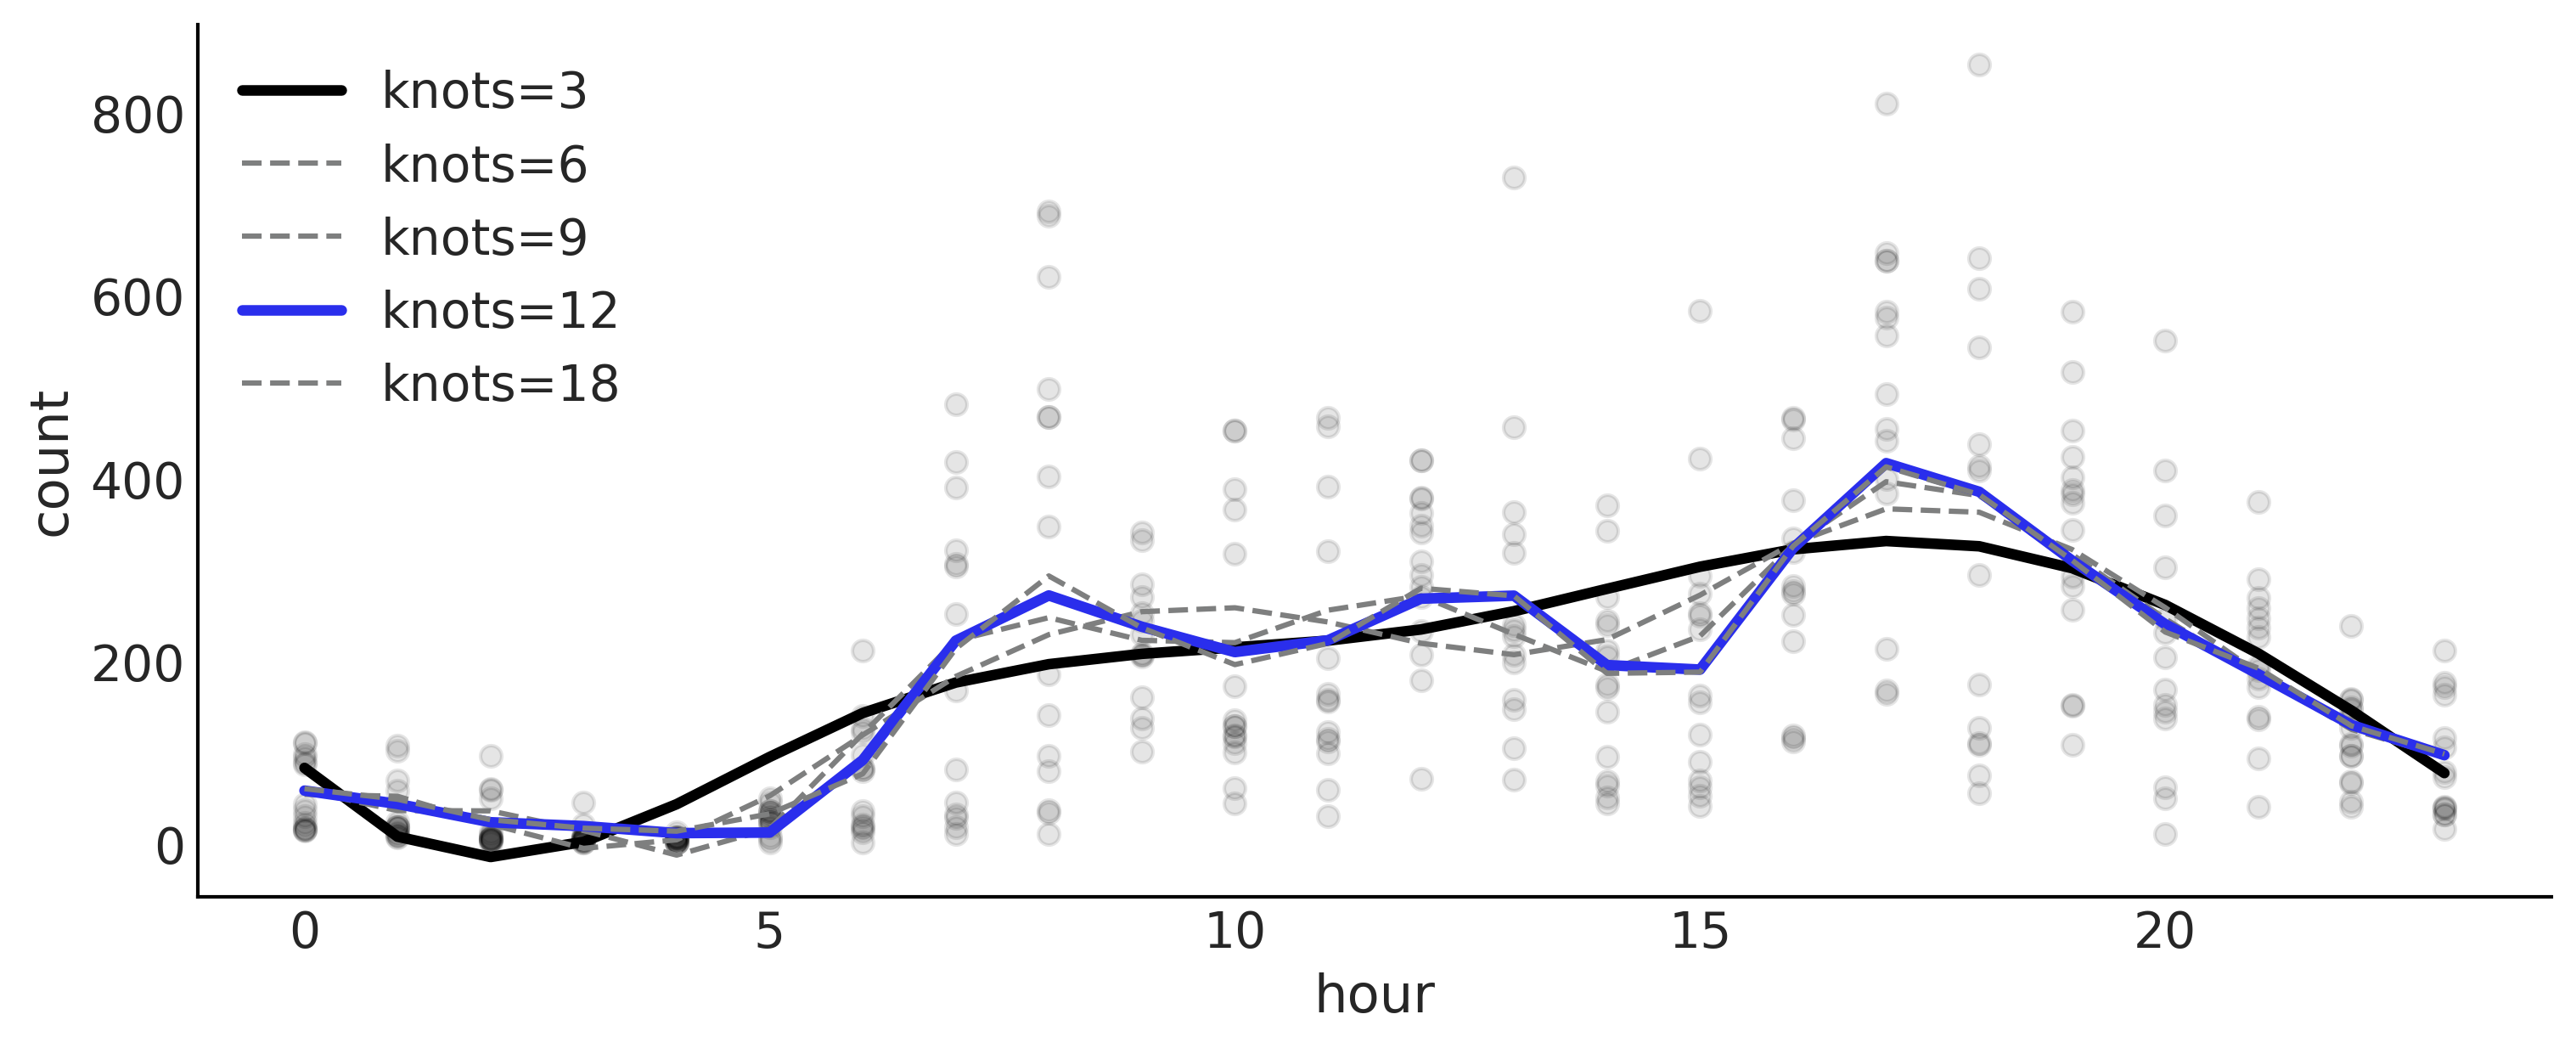

In [22]:
_, ax = plt.subplots(figsize=(10, 4))
ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

for idx, (idata, i, ls, lw) in enumerate(zip(idatas, (0,2,2,4,2), ("-","--","--","-","--"), (3,1.5,1.5,3,1.5))):
    mean_f = idata.posterior["μ"].mean(dim=['chain', 'draw'])
    ax.plot(data.hour,
            (mean_f * data_cnt_os) + data_cnt_om, color=f"C{i}",
            label=f"knots={(3, 6, 9, 12, 18)[idx]}" ,
            ls=ls, lw=lw)

plt.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_loo_knots.png")

One piece of advice that may help decide the locations of knots is to
place them based on quantiles, instead of uniformly. In Code Block
[knot_list](knot_list) we could have defined the
`knot_list` using
`knot_list = np.quantile(data.hour, np.linspace(0, 1, num_knots))`. In
this way we will be putting more knots where we have more data and less
knots where less data. This translates into a more flexible
approximation for data-richer portions.

(regularizing-prior-for-splines)=

### 5.6.1 Regularizing Prior for Splines

As choosing too few knots could lead to under-fitting and too many to
overfitting, we may want to use a *rather large* number of knots and
then choose a regularizing prior. From the definition of splines and
{numref}`fig:splines_weighted` we can see that the closer the
consecutive $\boldsymbol{\beta}$ coefficients are to each other, the
smoother the resulting function will be. Imagine you are dropping two
consecutive columns of the design matrix in
{numref}`fig:splines_weighted`, effectively setting those coefficients
to 0, the fit will be much less *smooth* as we do not have enough
information in the predictor to cover some sub region (recall that
splines are *local*). Thus we can achieve smoother fitted regression
line by choosing a prior for the $\boldsymbol{\beta}$ coefficients in
such a way that the value of $\beta_{i+1}$ is correlated with the value
of $\beta_{i}$:

```{math}
:label: eq:spline_regularized_prior
\begin{aligned}
\begin{split}
\beta_i \sim& \mathcal{N}(0, 1) \\
\tau\sim& \mathcal{N}(0,1) \\
\beta \sim& \mathcal{N}(\beta_{i-1}, \tau) 
\end{split}\end{aligned}
```

Using PyMC3 we can write an equivalent version using a Gaussian Random
Walk prior distribution:

```{math}
:label: eq:spline_regularized_GW_prior
\begin{aligned}
\begin{split}
\tau\sim& \mathcal{N}(0, 1) \\
\beta \sim& \mathcal{G}RW(\beta, \tau) 
\end{split}\end{aligned}
```

To see the effect of this prior we are going to repeat the analysis of
the bike dataset, but this time using `num_knots = 12`. We refit the
data using `splines` model and the following model:

```{code-block} python
:name: splines_rw
:caption: splines_rw
with pm.Model() as splines_rw:
    τ = pm.HalfCauchy("τ", 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(B, β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_splines_rw = pm.sample(1000)
```

On {numref}`fig:bikes_spline_data_grw` we can see that the spline mean
function for the model `splines_rw` (black line) is less wiggly than the
spline mean function without smoothing prior (gray thick line), although
we admit that the difference seems to be rather small.

```{figure} figures/bikes_spline_data_grw.png
:name: fig:bikes_spline_data_grw
:width: 8.00in
Bikes data fitted with either a Gaussian prior (black) or a regularizing
Gaussian Random Walk Prior (blue). We use 22 knots for both cases. The
black line corresponds to the mean spline function computed from
`splines` model. The blue line is the mean function for the model
`splines_rw`.
```

In [23]:
knot_list = np.arange(1, 23)

In [24]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

In [25]:
with pm.Model() as splines_rw:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"])
    idata_splines_rw = pm.sample(1000)
    idata_splines_rw.extend(pm.sample_posterior_predictive(idata_splines_rw))

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [c]


Output()

In [26]:
with pm.Model() as wiggly:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"])
    idata_wiggly = pm.sample(1000)
    idata_wiggly.extend(pm.sample_posterior_predictive(idata_wiggly))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [c]


Output()

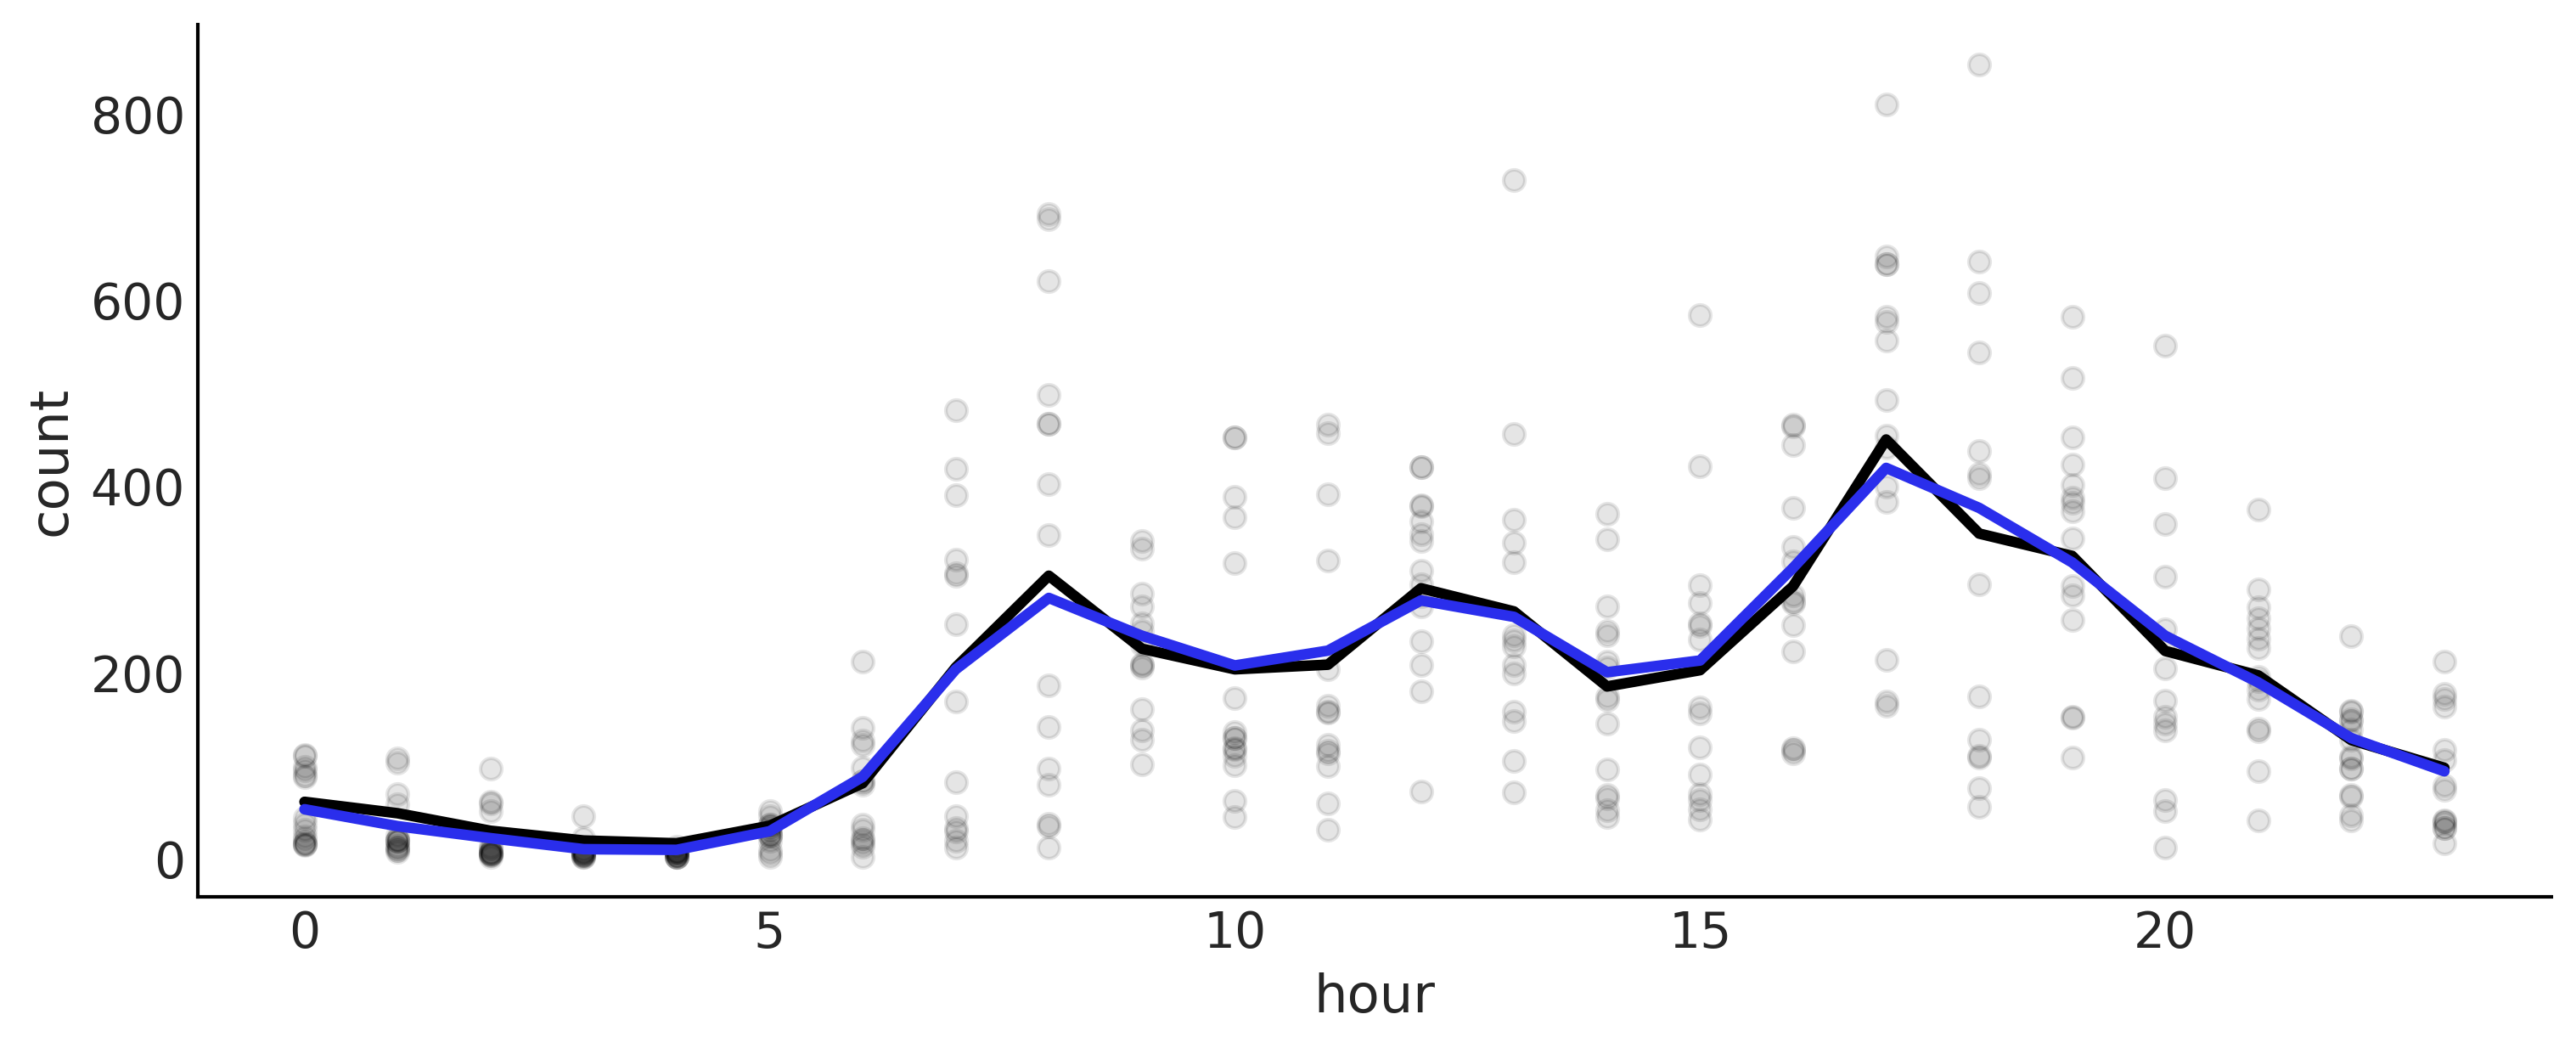

In [27]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

wiggly_posterior = (idata_wiggly.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = wiggly_posterior.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f , color="C0", lw=3)
#az.plot_hdi(data.hour, wiggly_posterior, smooth=False, color="C0")

splines_rw = (idata_splines_rw.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = splines_rw.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f, color="C4", lw=3)
#az.plot_hdi(data.hour, splines_rw, smooth=False, color="C4")

ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data_grw.png")

(modeling-co2-uptake-with-splines)=

## 5.7 Modeling CO₂ Uptake with Splines

For a final example of splines we are going to use data from an
experimental study {cite:p}`Potvin1990, Pedersen2019`. The experiment consists
of measuring the CO₂ uptake in 12 different plants under varying
conditions. Here we will only explore the effect of the external CO₂
concentration, i.e. how the CO₂ concentration in the environment
affects the consumption of CO₂ by different plants. The CO₂ uptake
was measured at seven CO₂ concentrations for each plant, the same
seven values for each one of the 12 plants. Let us begin by loading and
tidying up the data.

```{code-block} python
:name: plants_co2_import
:caption: plants_co2_import

plants_CO2 = pd.read_csv("../data/CO2_uptake.csv")
plant_names = plants_CO2.Plant.unique()

# Index the first 7 CO2 measurements per plant
CO2_conc = plants_CO2.conc.values[:7]

# Get full array which are the 7 measurements above repeated 12 times
CO2_concs = plants_CO2.conc.values
uptake = plants_CO2.uptake.values

index = range(12)
groups = len(index)
```

In [28]:
np.random.seed(435)

In [29]:
plants_CO2 = pd.read_csv("../data/CO2_uptake.csv")
plant_names = plants_CO2.Plant.unique()
CO2_conc = plants_CO2.conc.values[:7]
CO2_concs = plants_CO2.conc.values
uptake = plants_CO2.uptake.values
index = list(range(12))
groups = len(index)

The first model we are going to fit is one with a single response curve,
i.e. assuming the response curve is the same for all the 12 plants. We
first define the design matrix, using Patsy, just as we previously did.
We set `num_knots=2` because we have 7 observations per plant, so a
relatively low number of knots should work fine. In Code Block
[plants_co2_import](plants_co2_import), `CO2_concs` is a
list with the values `[95, 175, 250, 350, 500, 675, 1000]` repeated 12
times, one time per plant.

```python
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots+2)[1:-1]

Bg = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_concs, "knots": knot_list})
```

In [30]:
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots+2)[1:-1]

Bg = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_concs, "knots": knot_list},
)

This problem looks similar to the bike rental problem from previous
sections and thus we can start by applying the same model. Using a model
that we have already applied in some previous problem or the ones we
learned from the literature is a good way to start an analysis. This
model-template approach can be viewed as a shortcut to the otherwise
longer process of model design {cite:p}`Gelman2020`. In addition to the obvious
advantage of not having to think of a model from scratch, we have other
advantages such as having better intuition of how to perform exploratory
analysis of the model and then possible routes for making changes into
the model either to simplify it or to make it more complex.

```{code-block} python
:name: sp_global
:caption: sp_global

with pm.Model() as sp_global:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(Bg, β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg, σ, observed=uptake)
    idata_sp_global = pm.sample(2000, return_inferencedata=True)
```

From {numref}`fig:sp_global` we can clearly see that the model is only
providing a good fit for some of the plants. The model is good on
average, i.e. if we pool all the species together, but not very good for
specific plants.

```{figure} figures/sp_global.png
:name: fig:sp_global
:width: 8.00in
The black dots represents the CO₂ uptake measured at seven CO₂
concentrations for each one of 12 plants (Qn1, Qn2, Qn3, Qc1, Qc2, Qc3,
Mn1, Mn2, Mn3, Mc1, Mc2, Mc3). The black line is the mean spline fit
from the model in Code Block [sp_global](sp_global) and
the gray shaded curve represents the 94% HDI interval for that fit.
```

In [31]:
with pm.Model() as sp_global:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(Bg), β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg, σ, observed=uptake)
    idata_sp_global = pm.sample(3000, tune=2000, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 5 seconds.


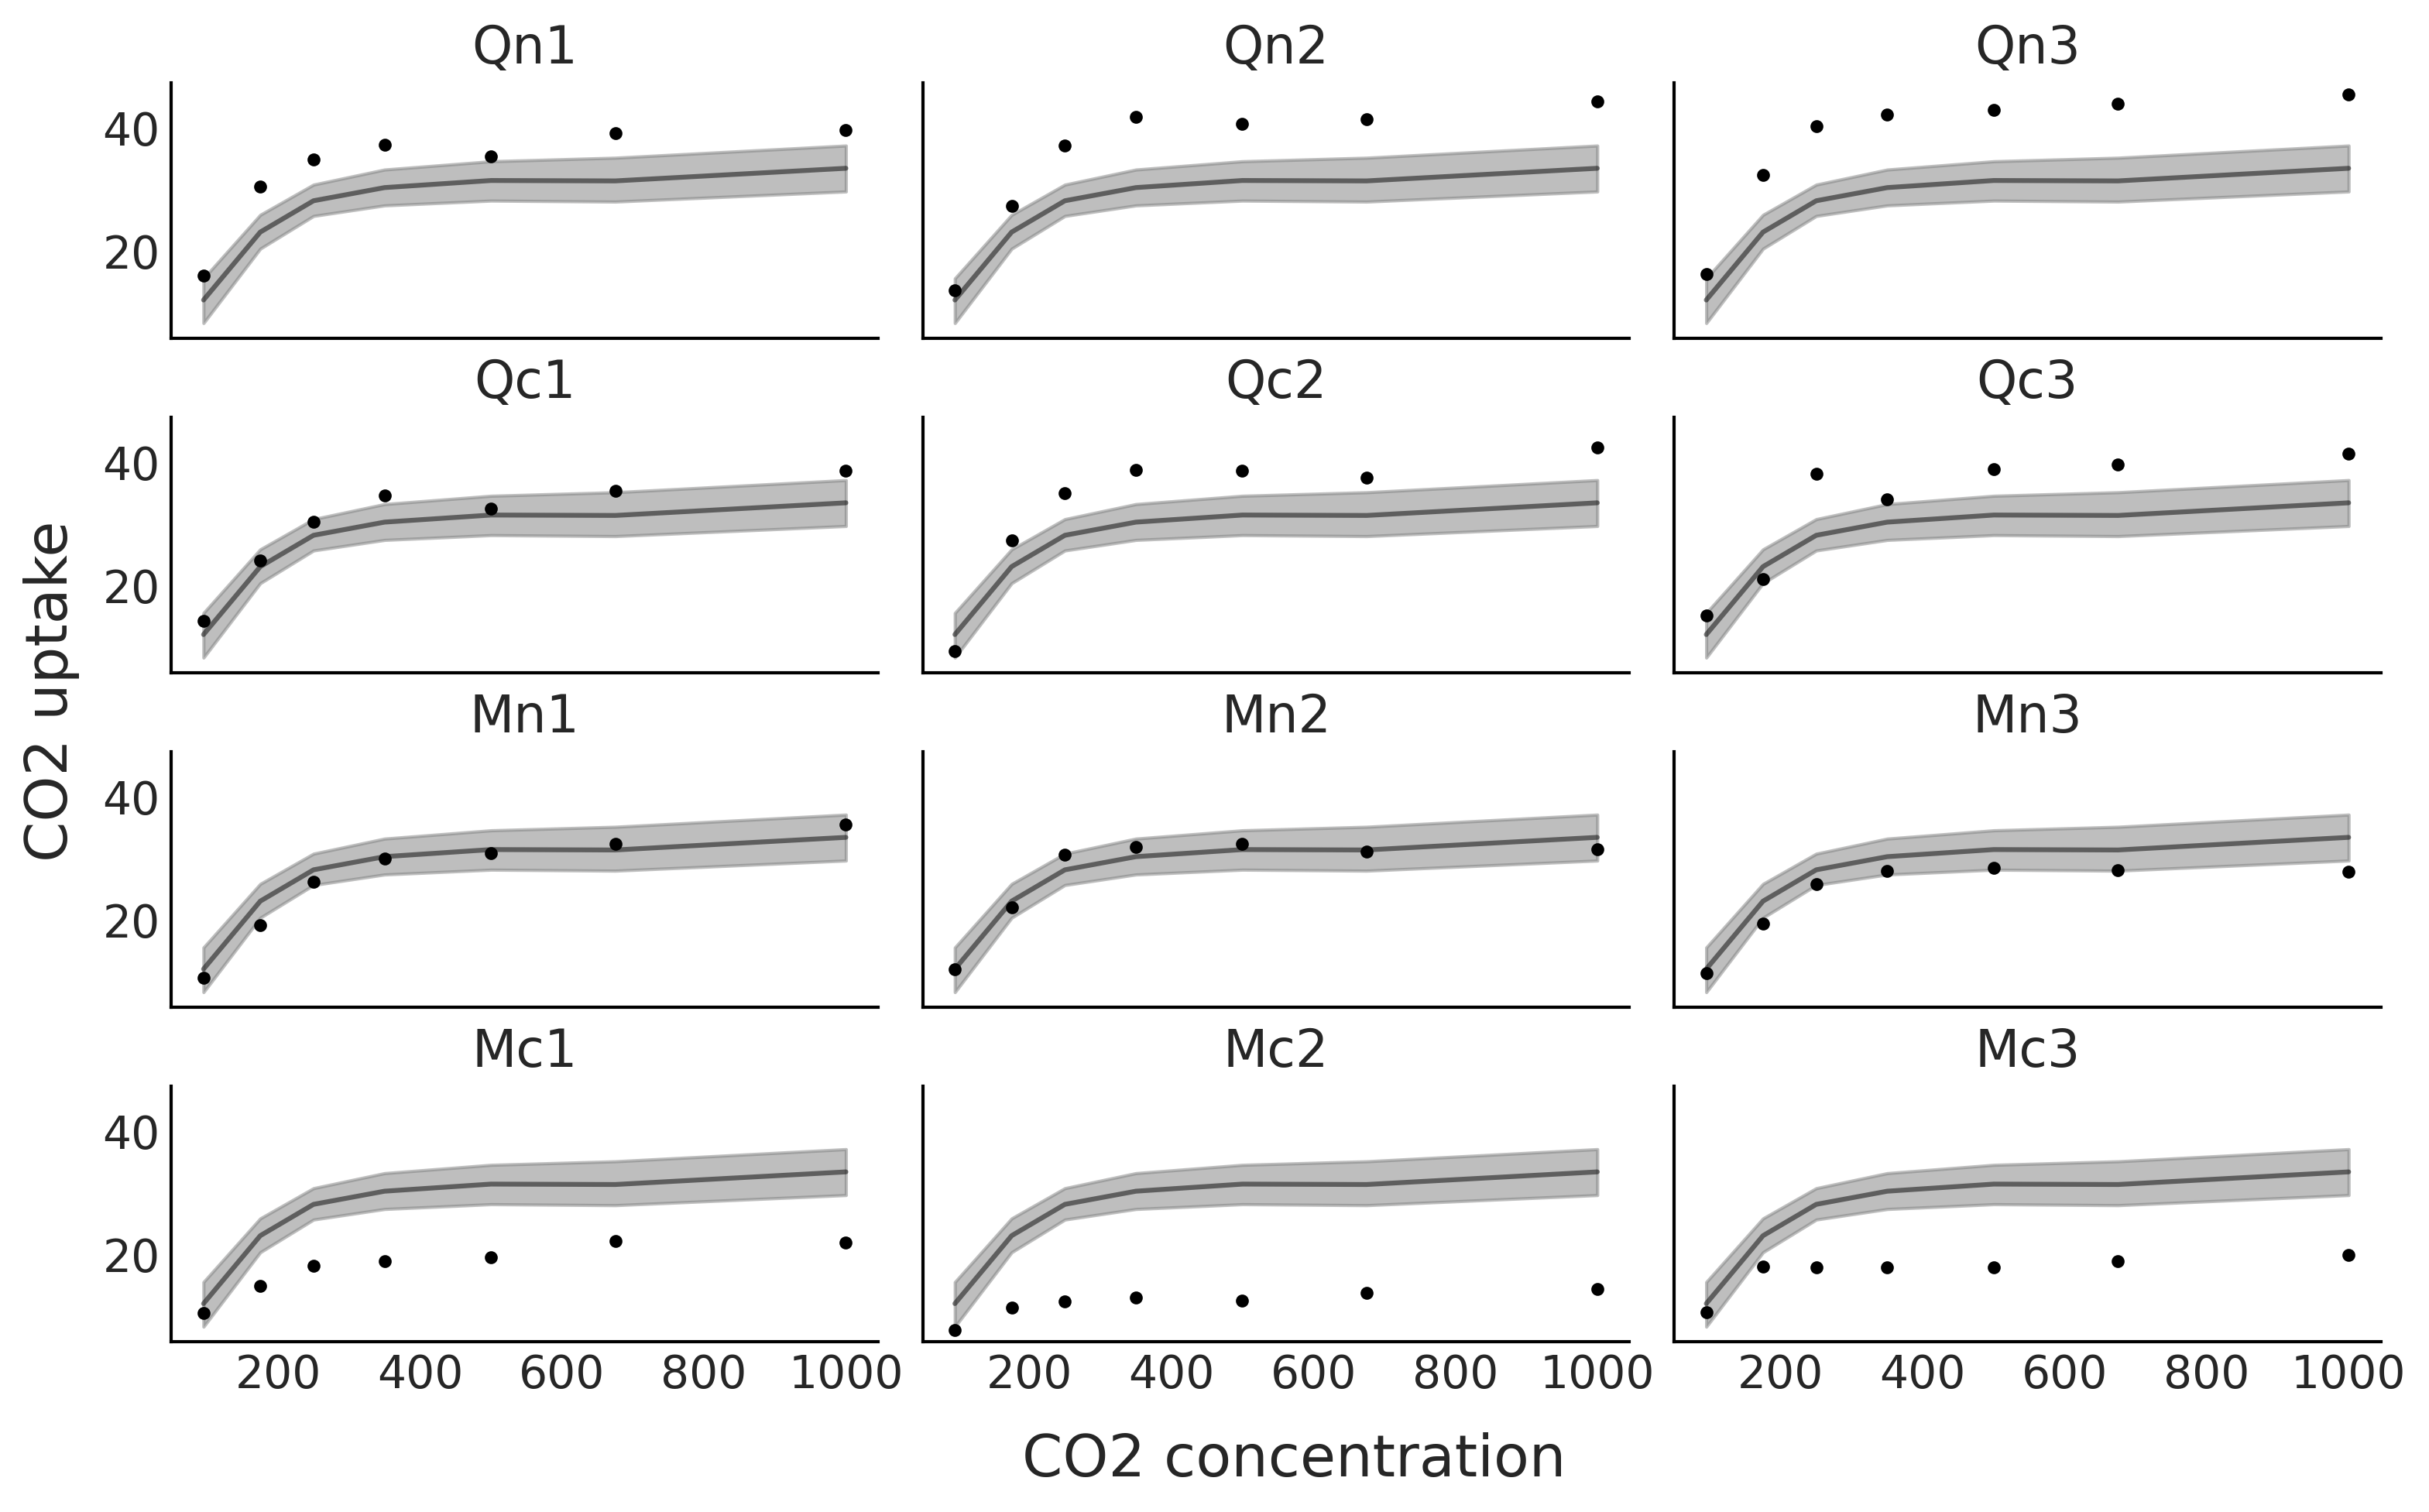

In [32]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)
μsg = idata_sp_global.posterior.stack(draws=("chain", "draw"))["μg"].values.T
μsg_mean = μsg.mean(0)
for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsg_mean[idx:idx+7], "k", alpha=0.5);
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.05, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("img/chp05/sp_global.png", bbox_inches='tight')

Let us try now with a model with a different response per plant, in
order to do this we define the design matrix `Bi` in Code Block
[Bi_matrix](Bi_matrix). To define `Bi` we use the list
`CO2_conc = [95,  175,  250,  350,  500,  675, 1000]`, thus `Bi` is a
$7 \times 7$ matrix while `Bg` is a $84 \times 7$ matrix.

```{code-block} python
:name: Bi_matrix
:caption: Bi_matrix

Bi = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_conc, "knots": knot_list})
```

In [33]:
Bi = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_conc, "knots": knot_list},
)

Accordingly with the shape of `Bi`, the parameter $\beta$ in Code Block
[sp_individual](sp_individual) has now shape
`shape=(Bi.shape[1], groups))` (instead of `shape=(Bg.shape[1]))`) and
we reshape `μi[:,index].T.ravel()`

```{code-block} python
:name: sp_individual
:caption: sp_individual

with pm.Model() as sp_individual:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(Bi, β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_individual = pm.sample(2000, return_inferencedata=True)
```

From {numref}`fig:sp_individual` we can now see that we have a much
better fit for each one of the 12 plants.

```{figure} figures/sp_individual.png
:name: fig:sp_individual
:width: 8.00in
CO₂ uptake measured at seven CO₂ concentrations for 12 plants. The
black line is the mean spline fit from the model in Code Block
[sp_individual](sp_individual) and the gray shaded curve
represents the 94% HDI interval for that fit.
```

In [34]:
with pm.Model() as sp_individual:
    τ = pm.HalfCauchy('τ', 1)
    βi = pm.Normal("βi", mu=0, sigma=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(Bi), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_individual = pm.sample(3000, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, βi, σ]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 13 seconds.


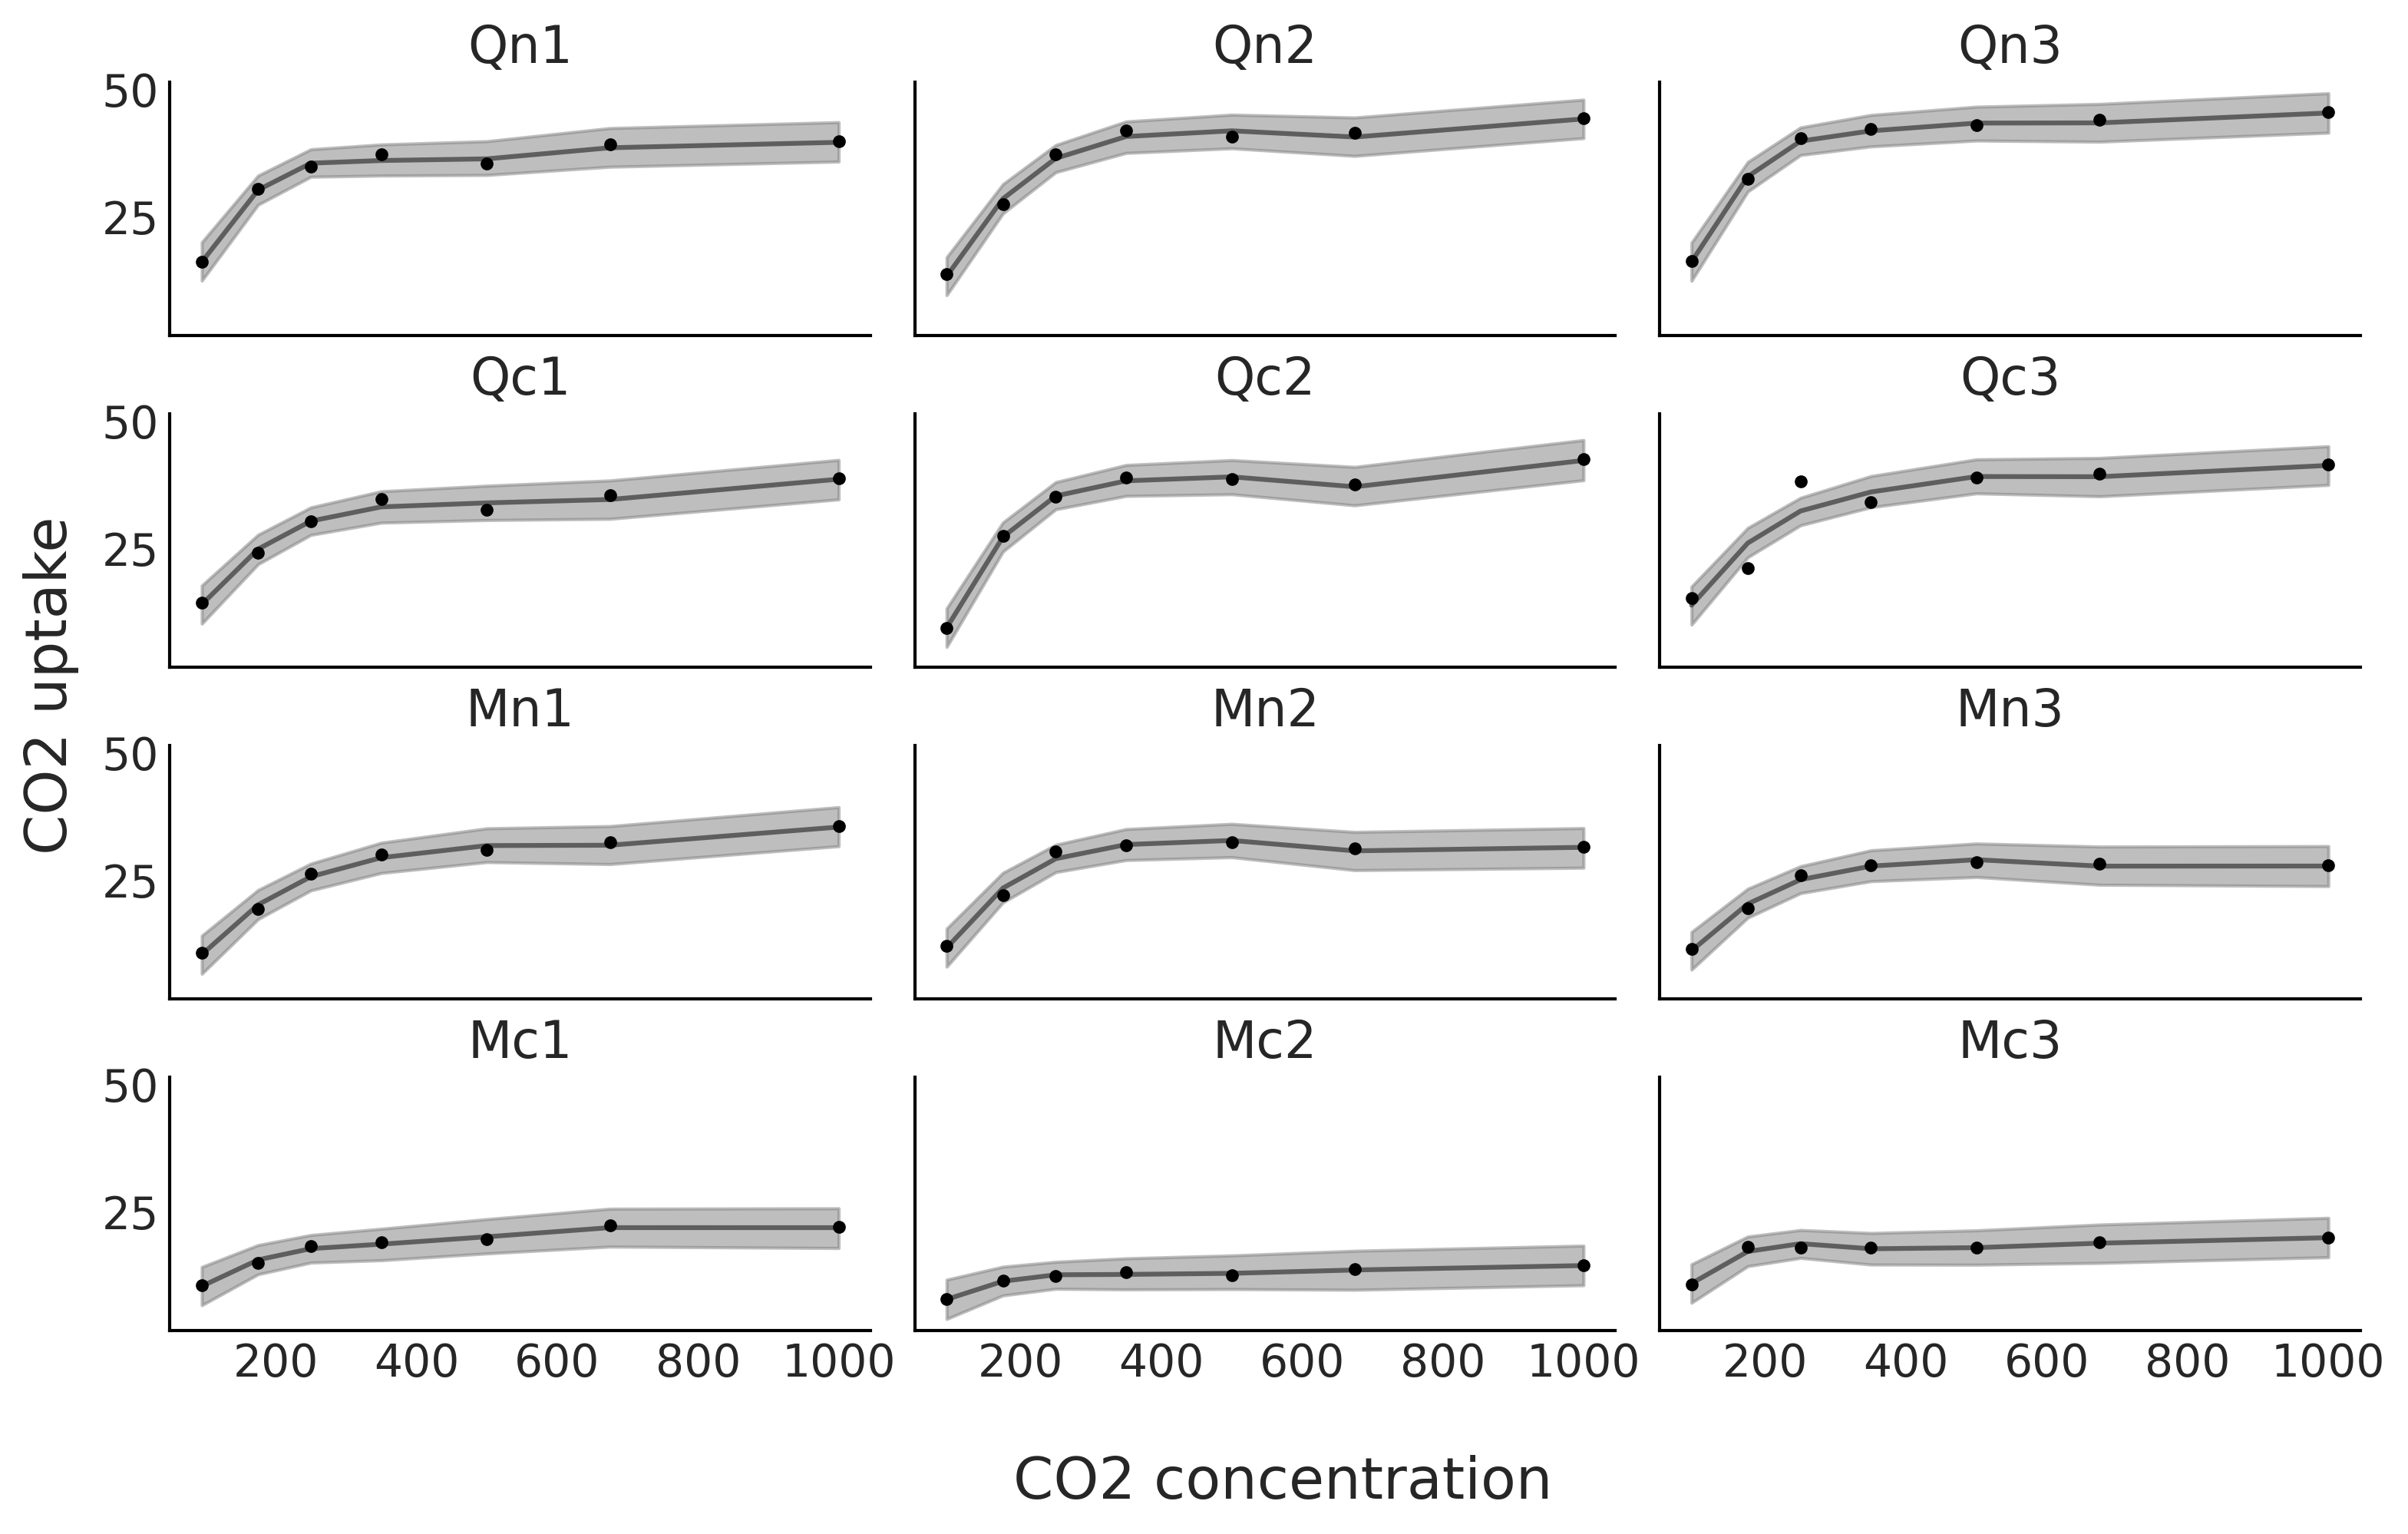

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

μsi = idata_sp_individual.posterior.stack(draws=("chain", "draw"))["μi"].values.T
μsi_mean = μsi.mean(0)
for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(CO2_conc, μsi[:,index[count]], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("img/chp05/sp_individual.png", bbox_inches='tight')

We can also mix both previous models [^13]. This may be interesting if
we want to estimate a global trend for the 12 plants plus individual
fits. Model `sp_mix` in Code Block [sp_mix](sp_mix) use
both previously defined design matrices `Bg` and `Bi`.

```{code-block} python
:name: sp_mix
:caption: sp_mix

with pm.Model() as sp_mix:
    τ = pm.HalfCauchy("τ", 1)
    βg = pm.Normal("βg", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(Bg, βg))
    βi = pm.Normal("βi", mu=0, sigma=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(Bi, βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg+μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_mix = pm.sample(2000, return_inferencedata=True)
```

{numref}`fig:sp_mix_decomposed` show the fit of model `sp_mix`. One
advantage of this model is that we can decompose the individual fit (in
blue) into two terms, a global trend, in black, and the deviation of
that trend for each plant, in gray. Notice how the global trend, in
black, is repeated in each subplot. We can see that the deviations are
different not only in the average uptake, i.e. they are not flat
straight lines, but they are also different, to various extents, in the
shape of their functional responses.

```{figure} figures/sp_mix_decomposed.png
:name: fig:sp_mix_decomposed
:width: 8.00in
CO₂ uptake measured at seven CO₂ concentrations for 12 plants. The
blue line is the mean spline fit from model in Code Block
[sp_mix](sp_mix) and the gray shaded curve represents the
94% HDI interval for that fit. This fit is decomposed into two terms. In
black, and a dark gray band, the global contribution and in gray, and a
light gray band, the deviations from that global contribution. The blue
line, and blue band, is the sum of the global trend and deviations from
it.
```

[^13]: Yes, this is also known as a mixed-effect model, you might recall
    the related concept we discussed in Chapter [4](chap3).

In [36]:
with pm.Model() as sp_mix:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(Bg), β))
    βi = pm.Normal("βi", mu=0, sigma=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(Bi), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg+μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_mix = pm.sample(3000, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, βi, σ]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.


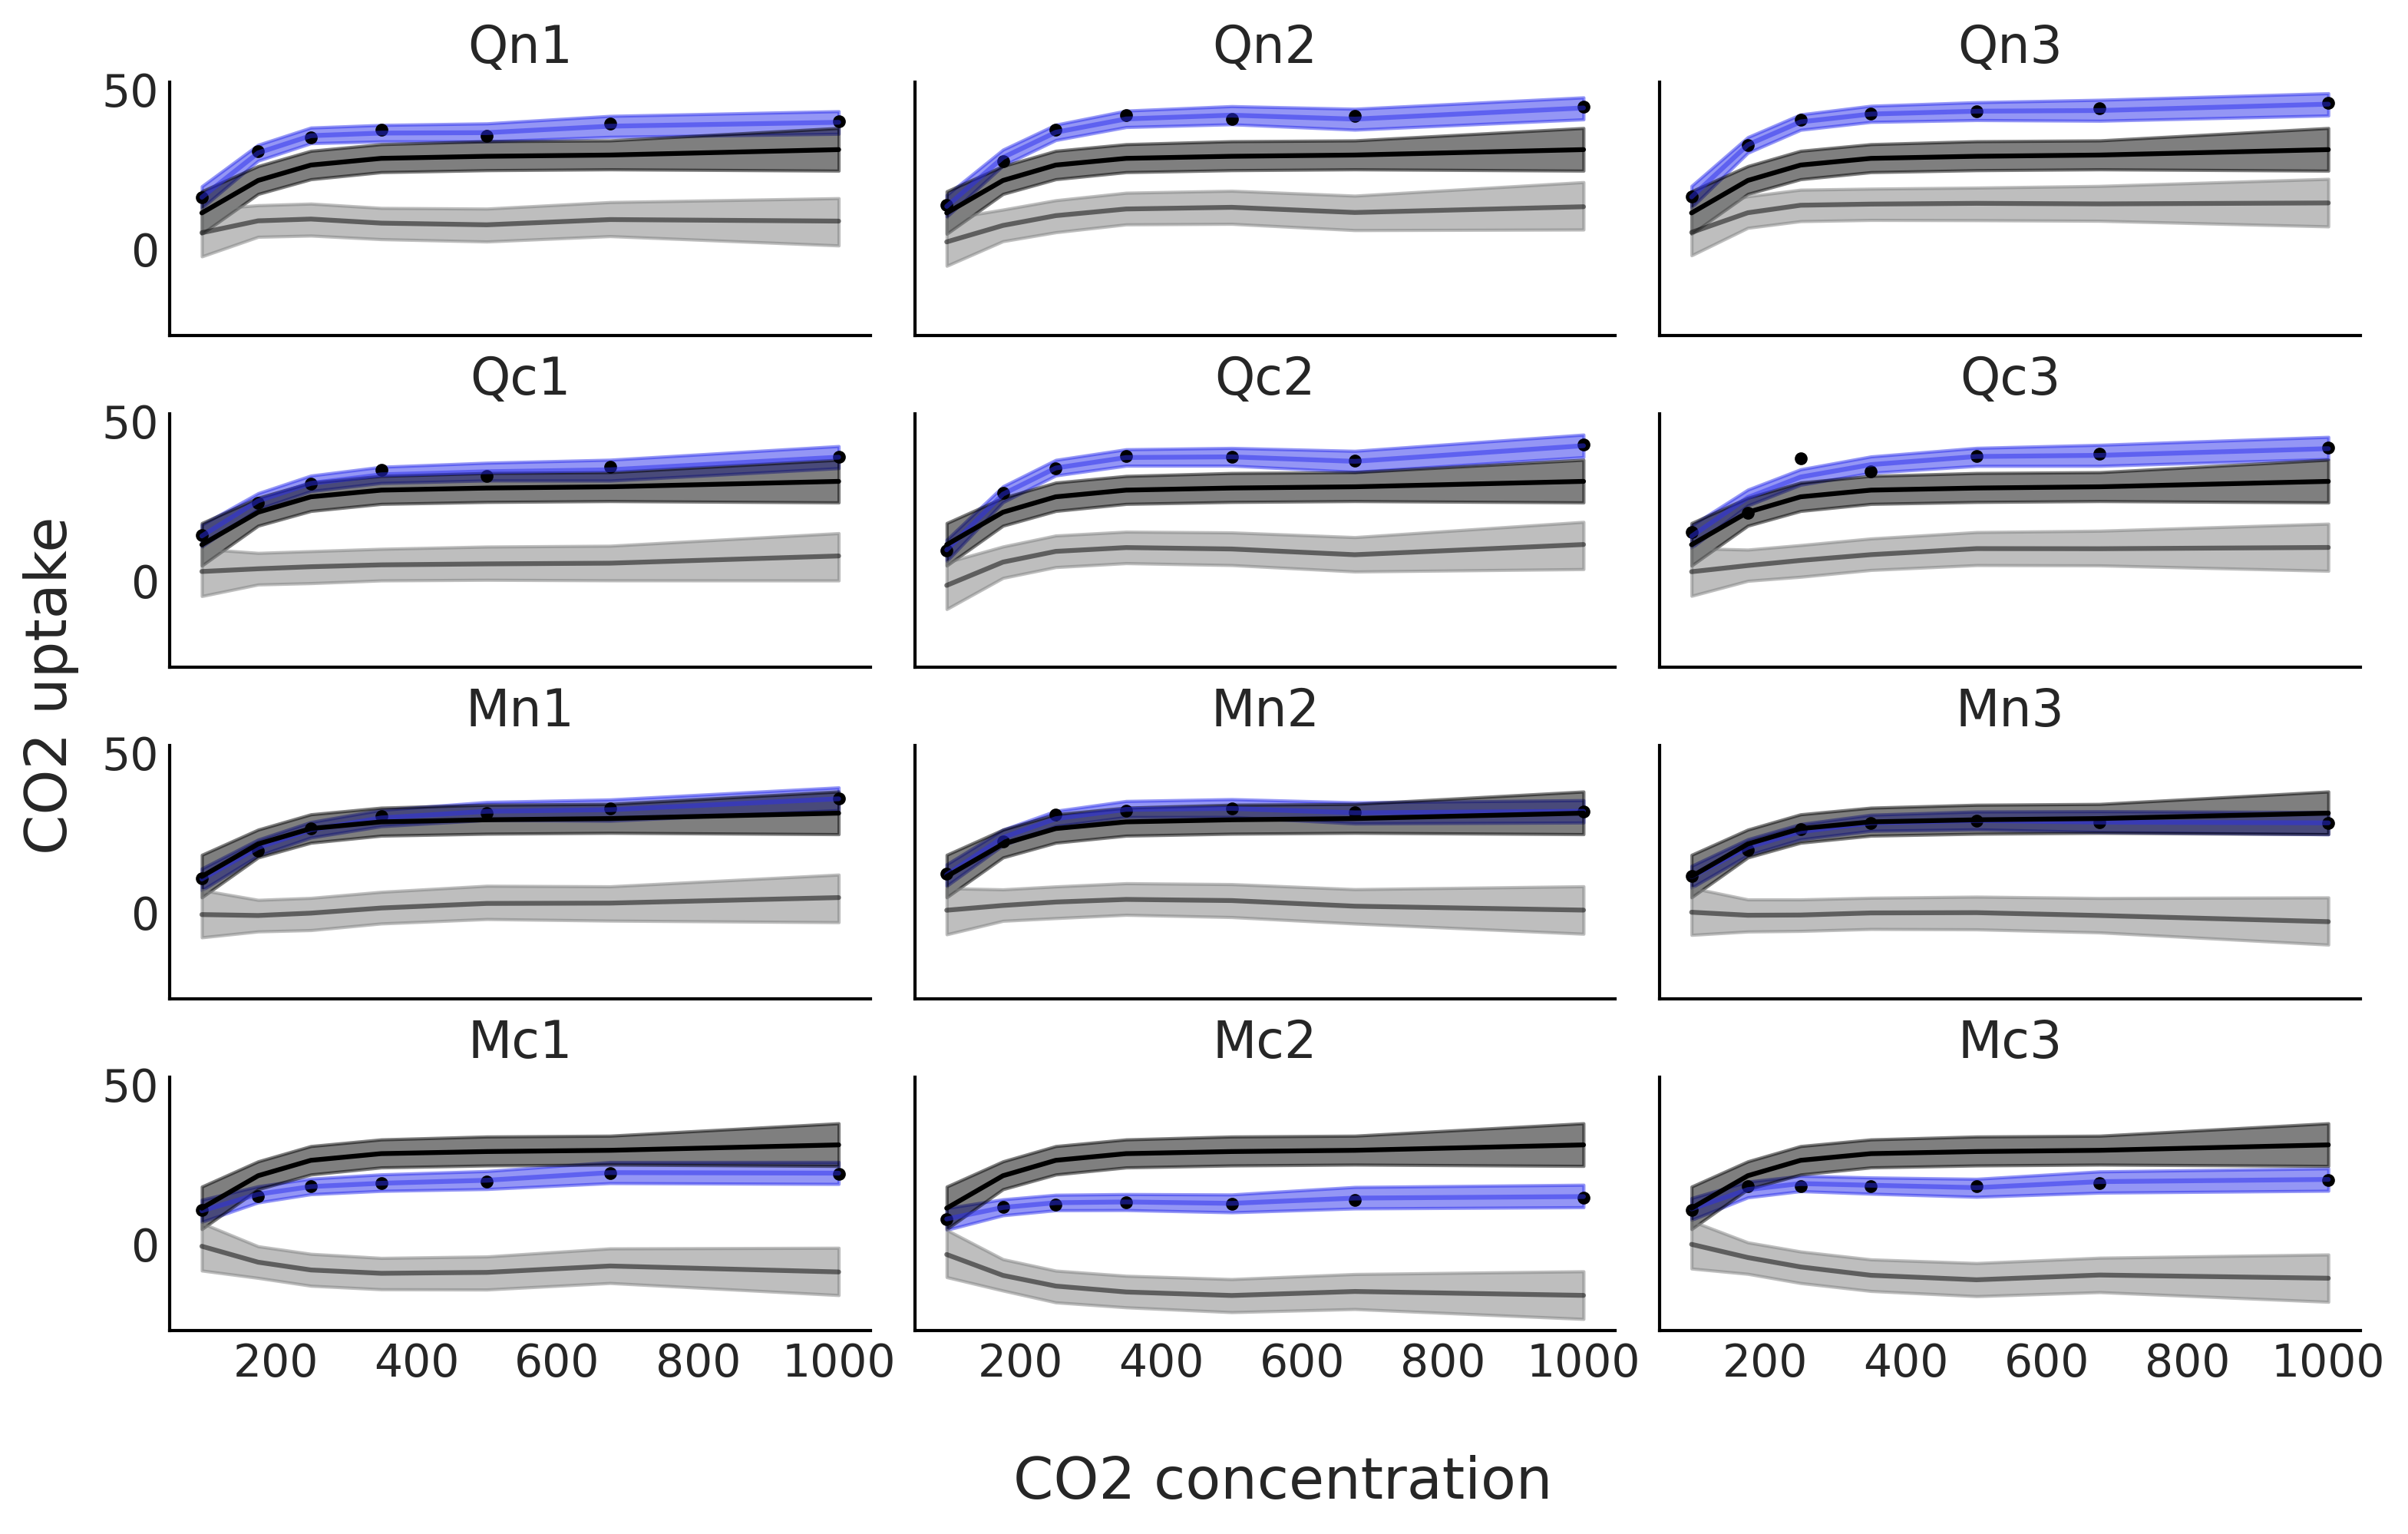

In [37]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

μsg = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μg"].values.T
μsg_mean = μsg.mean(0)

μsi = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μi"].values.T
μsi_mean = μsi.mean(0)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsg_mean[idx:idx+7]+μsi_mean[index[count]], "C4", alpha=0.5)
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7]+μsi[:,index[count]], color="C4", smooth=False,ax=ax)
    
    ax.plot(CO2_conc, μsg_mean[idx:idx+7], "k")
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7], color="k", smooth=False,ax=ax)
    
    ax.plot(CO2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(CO2_conc, μsi[:,index[count]], color="C2", smooth=False,ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
plt.savefig("img/chp05/sp_mix_decomposed.png", bbox_inches='tight')

{numref}`fig:sp_compare` shows that according to LOO `sp_mix` is a
better model than the other two. We can see there is still some
uncertainty about this statement as the standard errors for models
`sp_mix` and `sp_individual` partially overlap. We can also see that
models `sp_mix` and `sp_individual` are penalized harder than
`sp_global` (the distance between the empty circle and black circle is
shorter for `sp_global`). We note that LOO computation returns warnings
about the estimated shape parameter of Pareto distribution being greater
than 0.7. For this example we are going to stop here, but for a real
analysis, we should pay further attention to these warnings and try to
follow some of the actions described in Section {ref}`k-paretto`.

```python
cmp = az.compare({"global":idata_sp_global, 
                  "individual":idata_sp_individual, 
                  "mix":idata_sp_mix})
```

```{figure} figures/sp_compare.png
:name: fig:sp_compare
:width: 8.00in
Model comparison using LOO for the 3 different CO₂ uptake models
discussed in this chapter (`sp_global`, `sp_individual`, `sp_mix`).
Models are ranked from higher predictive accuracy to lower. The open
dots represent the values of LOO, the black dots are the in-sample
predictive accuracy. The black segments represent the standard error for
the LOO computations. The gray segments, centered at the triangles,
represent the standard errors of the difference between the values of
LOO for each model and the best ranked model.
```


In [38]:
cmp = az.compare({"sp_global":idata_sp_global, 
                  "sp_individual":idata_sp_individual, 
                  "sp_mix":idata_sp_mix})
cmp

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff        weight  \
sp_mix            0 -216.697848  57.591333   0.000000  9.586998e-01   
sp_individual     1 -229.183044  62.832184  12.485196  3.519696e-12   
sp_global         2 -307.445602   9.024882  90.747754  4.130025e-02   

                      se        dse  warning scale  
sp_mix         12.805914   0.000000     True   log  
sp_individual  11.273862   2.377219     True   log  
sp_global       9.002963  16.053338    False   log

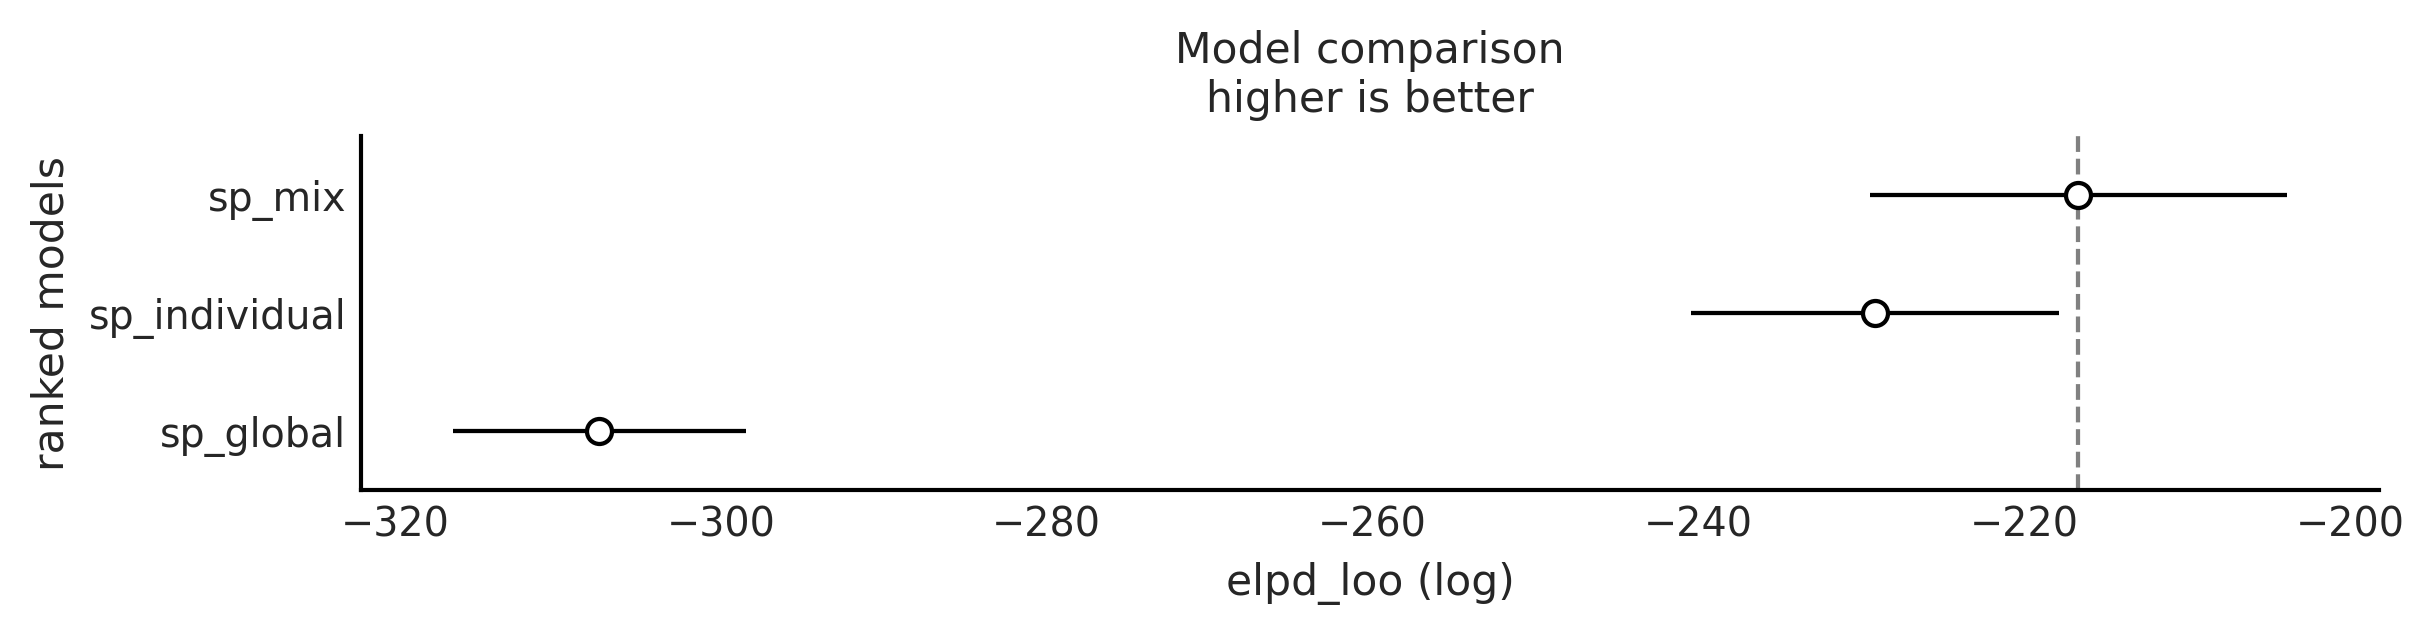

In [39]:
az.plot_compare(cmp, insample_dev=False, figsize=(8, 2))
plt.savefig("img/chp05/sp_compare.png")

(exercises5)=

## 5.8 Exercises

**5E1.**. Splines are quite powerful so its good to know
when and where to use them. To reinforce this explain each of the
following

1.  The differences between linear regression and splines.

2.  When you may want to use linear regression over splines

3.  Why splines is usually preferred over polynomial regression of high
    order.

**5E2.** Redo {numref}`fig:polynomial_regression` but
fitting a polynomial of degree 0 and of degree 1. Does they look similar
to any other type of model. Hint: you may want to use the code in the
GitHub repository.

**5E3.** Redo {numref}`fig:piecewise` but changing the
value of one or the two knots. How the position of the knots affects the
fit? You will find the code in the GitHub repository.

**5E4.** Below we provide some data. To each data fit a 0,
1, and 3 degree spline. Plot the fit, including the data and position of
the knots. Use `knots = np.linspace(-0.8, 0.8, 4)`. Describe the fit.

1.  `x = np.linspace(-1, 1., 200)` and `y = np.random.normal(2*x, 0.25)`

2.  `x = np.linspace(-1, 1., 200)` and
    `y = np.random.normal(x**2, 0.25)`

3.  pick a function you like.

**5E5.** In Code Block
[bikes_dmatrix](bikes_dmatrix) we used a non-cyclic aware
design matrix. Plot this design matrix. Then generate a cyclic design
matrix. Plot this one too what is the difference?

**5E6.** Generate the following design matrices using
Patsy.

```python
x = np.linspace(0., 1., 20)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False) +1",
            {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) +1",
            {"x": x, "knots":knots})
B2 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False) -1",
            {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) -1",
            {"x": x, "knots":knots})
```

1.  What is the shape of each one of the matrices? Can you justify the
    values for the shapes?

2.  Could you explain what the arguments `include_intercept=True/False`
    and the `+1/-1` do? Try generating figures like
    {numref}`fig:splines_basis` and {numref}`fig:design_matrices` to
    help you answer this question


**5E7.** Refit the bike rental example using the options
listed below. Visually compare the results and try to explain the
results:

1.  Code Block [knot_list](knot_list) but do not remove
    the first and last knots (i.e. without using 1:-1)

2.  Use quantiles to set the knots instead of spacing them linearly.

3.  Repeat the previous two points but with less knots

**5E8.** In the GitHub repository you will find the spectra
dataset use it to:

1.  Fit a cubic spline with knots
    `np.quantile(X, np.arange(0.1, 1, 0.02))` and a Gaussian prior (like
    in Code Block [splines](splines))

2.  Fit a cubic spline with knots
    `np.quantile(X, np.arange(0.1, 1, 0.02))` and a Gaussian Random Walk
    prior (like in Code Block [splines_rw](splines_rw))

3.  Fit a cubic spline with knots
    `np.quantile(X, np.arange(0.1, 1, 0.1))` and a Gaussian prior (like
    in Code Block [splines](splines))

4.  compare the fits visually and using LOO

**5M9.** Redo {numref}`fig:piecewise` extending `x_max`
from 6 to 12.

1.  How this change affects the fit?

2.  What are the implications for extrapolation?

3.  add one more knot and make the necessary changes in the code so the
    fit actually use the 3 knots.

4.  change the position of the third new knot to improve the fit as much
    as possible.

**5M10.** For the bike rental example increase the number
of knots. What is the effect on the fit? Change the width of the prior
and visually evaluate the effect on the fit. What do you think the
combination of knot number and prior weights controls?

**5M11.** Fit the baby regression example from Chapter
[4](chap3) using splines.

**5M12.** In Code Block
[bikes_dmatrix](bikes_dmatrix) we used a non-circular
aware design matrix. Since we describe the hours in a day as cyclic, we
want to use cyclic splines. However, there is one wrinkle. In the
original dataset the hours range from 0 to 23, so using a circular
spline patsy would treat 0 and 23 are the same. Still, we want a
circular spline regression so perform the following steps.

1.  Duplicate the 0 hour data label it as 24.

2.  Generate a circular design matrix and a non-circular design matrix
    with this modified dataset. Plot the results and compare.

3.  Refit the bike spline dataset.

4.  Explain what the effect of the circular spine regression was using
    plots, numerical summaries, and diagnostics.

**5M13.** For the rent bike example we use a Gaussian as
likelihood, this can be seen as a reasonable approximation when the
number of counts is large, but still brings some problems, like
predicting negative number of rented bikes (for example, at night when
the observed number of rented bikes is close to zero). To fix this issue
and improve our models we can try with other likelihoods:

1.  use a Poisson likelihood (hint you may need to restrict the $\beta$
    coefficients to be positive, and you can not normalize the data as
    we did in the example). How the fit differs from the example in the
    book. is this a better fit? In what sense?

2.  use a NegativeBinomial likelihood, how the fit differs from the
    previous two? Could you explain the differences (hint, the
    NegativeBinomial can be considered as a mixture model of Poisson
    distributions, which often helps to model overdispersed data)

3.  Use LOO to compare the spline model with Poisson and
    NegativeBinomial likelihoods. Which one has the best predictive
    performance?

4.  Can you justify the values of `p_loo` and the values of
    $\hat \kappa$?

5.  Use LOO-PIT to compare Gaussian, NegativeBinomial and Poisson models


**5M14.** Using the model in Code Block
[splines](splines) as a guide and for $X \in [0, 1]$, set
$\tau \sim \text{Laplace}(0, 1)$:

1.  Sample and plot realizations from the prior for $\mu$. Use different
    number and locations for the knots

2.  What is the prior expectation for $\mu(x_i)$ and how does it depend
    on the knots and X?

3.  What is the prior expectation for the standard deviations of
    $\mu(x_i)$ and how does it depend on the knots and X?

4.  Repeat the previous points for the prior predictive distribution

5.  Repeat the previous points using a $\mathcal{H}\text{C}(1)$


**5M15.** Fit the following data. Notice that the response
variable is binary so you will need to adjust the likelihood accordingly
and use a link function.

1.  a logistic regression from a previous chapter. Visually compare the
    results between both models.

2.  Space Influenza is a disease which affects mostly young and old
    people, but not middle-age folks. Fortunately, Space Influenza is
    not a serious concern as it is completely made up. In this dataset
    we have a record of people that got tested for Space Influenza and
    whether they are sick (1) or healthy (0) and also their age. Could
    you have solved this problem using logistic regression?

**5M16.** Besides "hour" the bike dataset has other
covariates, like "temperature". Fit a splines using both covariates. The
simplest way to do this is by defining a separated spline/design matrix
for each covariate. Fit a model with a NegativeBinomial likelihood.

1.  Run diagnostics to check the sampling is correct and modify the
    model and or sample hyperparameters accordingly.

2.  How the rented bikes depend on the hours of the day and how on the
    temperature?

3.  Generate a model with only the hour covariate to the one with the
    "hour" and "temperature". Compare both model using LOO, LOO-PIT and
    posterior predictive checks.

4.  Summarize all your findings